In [1]:
from peak_detector6 import Features, SignalHead, DeconvHead
from hierarchical_negbin import RecordGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
cols = ["#926cb6", "#93b793", "#d31d00", "#ff900d", "#fefb03", "black"]
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
first_run = 0

In [3]:
MAXBINS = 400

# inputs = tf.keras.Input(shape=(MAXBINS, 2), dtype=tf.float32)
# features = Features(nblocks=24, ksize=5, filters=64)(inputs)
# signal, peaks = SignalHead(nblocks=4, ksize=5, filters=64)([features, inputs])
# deconv = DeconvHead(nblocks=4, ksize=5, filters=64)([features, inputs])
# model_smoother = tf.keras.Model(inputs=inputs, outputs=[signal, peaks])
# model_deconv = tf.keras.Model(inputs=inputs, outputs=deconv)

inputs_smoother = tf.keras.Input(shape=(MAXBINS, 1), dtype=tf.float32)
inputs_deconv = tf.keras.Input(shape=(MAXBINS, 2), dtype=tf.float32)
feats_smoother = Features(ksize=7, filters=32, nblocks=12)(inputs_smoother)
feats_deconv = Features(ksize=7, filters=32, nblocks=16)(inputs_deconv)
signal, peaks = SignalHead(ksize=5, filters=32, nblocks_signal=2, nblocks_peaks=4)([feats_smoother, inputs_smoother])
deconv = DeconvHead(ksize=5, filters=32, nblocks=4)([feats_deconv, inputs_deconv])

model_smoother = tf.keras.Model(inputs=inputs_smoother, outputs=[signal, peaks])
model_deconv = tf.keras.Model(inputs=inputs_deconv, outputs=deconv)

In [4]:
model_smoother.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 400, 1)]                 0                                                                   
______________________________________________________________________________________________________________________________________________________
features (Features)                              (None, 400, 32)                  79616             input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
signal_head (SignalHead)                         ((None, 400, 1), (None, 400, 1

In [5]:
model_deconv.summary(line_length=150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_2 (InputLayer)                             [(None, 400, 2)]                 0                                                                   
______________________________________________________________________________________________________________________________________________________
features_1 (Features)                            (None, 400, 32)                  106224            input_2[0][0]                                     
______________________________________________________________________________________________________________________________________________________
deconv_head (DeconvHead)                         (None, 400, 1)              

In [6]:
# model_smoother.summary()

In [7]:
# model_deconv.summary()

In [8]:
# # do we need to load both???
# model_peaks.load_weights("tmp_peaks.h5")
# model_deconv.load_weights("tmp_deconv.h5")
# model.load_weights("tmp_one_to_rule_them_all3.h5")
# model.load_weights("tmp_one_to_rule_them_all_skl_elite.h5")
model_deconv.load_weights("tmp_back_to_two_deconv.h5")
model_smoother.load_weights("tmp_back_to_two_smoother.h5")

In [24]:
def lasso(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = x * tf.math.sqrt(nbins)
    x = tf.reduce_mean(tf.math.abs(x))
    return x


def ridge(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = tf.reduce_mean(x ** 2) * nbins
    return x


def tv(x):  
    x = tf.image.total_variation(x)
    x = tf.reduce_mean(x)
    return x

def tv2(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    out = tf.reduce_sum((x1 - x0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def tv_trend(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    out = tf.reduce_sum((z1 - z0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def llhood(y, yhat):
    nbins = tf.cast(tf.shape(y), tf.float32)[1]
    loss = tf.reduce_mean((y - yhat)**2) * nbins
    return loss

def kl(y, yhat):
    x = - y * tf.math.log((yhat + 1e-12) / (y + 1e-12))
    x = tf.math.reduce_sum(x, 1)
    loss = tf.math.reduce_mean(x)
    return loss

def skl(y, yhat):
    x = - 0.5 * y * tf.math.log((yhat + 1e-10) / (y + 1e-10))
    x += - 0.5 * yhat * tf.math.log((y + 1e-10) / (yhat + 1e-10))
    x = tf.math.reduce_sum(x, 1)
    loss = tf.math.reduce_mean(x)
    return loss

def corr(y, yhat):
    ymeans = tf.math.reduce_mean(y, 1, keepdims=True)
    ystd = tf.math.reduce_std(y, 1, keepdims=True)
    yhatmeans = tf.math.reduce_mean(yhat, 1, keepdims=True)
    yhatstd = tf.math.reduce_std(yhat, 1, keepdims=True)
    ynorm = (y - ymeans) / ystd
    yhatnorm = (yhat - yhatmeans) / yhatstd
    return - tf.reduce_mean(ynorm * yhatnorm)
    

def my_loss_density(y, yhat):
    return tv_trend(yhat) + 2.5 * tv2(yhat) + skl(y, yhat)


def my_loss_density_extra_reg(y, yhat):
    return tv_trend(yhat) + 10.0 * tv2(yhat) + skl(y, yhat)


def my_loss_peaks(y, yhat):
    out1 = - y * tf.math.log(yhat + 1e-10)  # upsampling
    out2 = - (1.0 - y) * tf.math.log(1.0 - yhat + 1e-10)
    return  tf.reduce_mean(out1 + out2) + 0.01 * tv2(yhat)

# def my_loss_wts(y, yhat):
#     return 0.005 * lasso(yhat) + kl(y, yhat)


model_smoother.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-5,
                clipnorm=10.0),
              loss=[my_loss_density, my_loss_peaks])

model_deconv.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-5,
                clipnorm=10.0),
              loss=my_loss_density_extra_reg)

# model.compile(optimizer=tf.keras.optimizers.Adam(
#             learning_rate=1e-3,
#             clipnorm=10.0),
#         loss=[my_loss_density, my_loss_peaks, my_loss_density_extra_reg])

In [25]:
generator = RecordGenerator(n_obs=(1500, 100000),
                            n_bins=(50, MAXBINS),
                            n_meanings=(1, 4),
                            noise_ratio=(0.1, 1.0),
                            noise_dispersion=(0.05, 1.5),
                            alpha_meanings=(1.0, 4.0),
                            rounding=list(range(1, 17)),
                            inner_mode_dist_tol=0.25,
                            inner_sigma_ratio=3.0,
                            max_sigma_to_bins_ratio=0.125,
                            sigmas=(1.0, 50.0),
                            trim_corners=True)

In [26]:
def standardize_bins(obs):
    L = len(obs)
    assert L < MAXBINS
    start = MAXBINS // 2 - L // 2
    end = start + L
    out = np.zeros(MAXBINS, dtype=int)
    out[start:end] = obs
    return out, start

def standardize_pdfs(pdf):
    L = len(pdf)
    assert L < MAXBINS
    start = MAXBINS // 2 - L // 2
    end = start + L
    out = np.zeros(MAXBINS, dtype=np.float32)
    out[start:end] = pdf
    return out
    
def prepare_network_input_output(obs, pdf, meaning_modes, meaning_pdfs):
    # assumes 1 vector of observation and possibly multiple peaks
    obs, start = standardize_bins(obs)
    meaning_modes = np.array([start + x for x in meaning_modes])
    x = np.array(obs, dtype=np.float32)
    x /= x.sum()
    xinput = x * np.sqrt(MAXBINS)
    xinput = np.expand_dims(xinput, 0)
    xinput = np.expand_dims(xinput, -1)
    #
    npeaks = len(meaning_modes)
    onehot_vecs = []
    for m in meaning_modes:
        z = np.zeros(MAXBINS, np.float32)
        z[m] = 1.0
#         z = 1.0 - z  #  necessary?
        onehot_vecs.append(z)
    peakinput = np.stack(onehot_vecs, 0)
    peakinput = np.expand_dims(peakinput, -1)
    #
    xstack = np.stack([np.squeeze(xinput, 0)] * npeaks, 0)
    deconv_input = np.concatenate([xstack, peakinput], -1)
    #
    meaning_pdfs_out = [standardize_pdfs(x) for x in meaning_pdfs]
    pdf_out = [standardize_pdfs(pdf)][0]
    # add layers of zero to x
#     smoother_input = np.concatenate([xinput, np.zeros_like(xinput)], -1)
    
    return x, xinput, peakinput, deconv_input, meaning_modes, meaning_pdfs_out, pdf_out, start
    
    
# def prepare_network_input_output(obs, pdf, meaning_modes, meaning_pdfs):
#     # assumes 1 vector of observation and possibly multiple peaks
#     obs, start = standardize_bins(obs)
#     meaning_modes = np.array([start + x for x in meaning_modes])
#     meaning_pdfs = [standardize_pdfs(x) for x in meaning_pdfs]
    
#     x = np.array(obs, dtype=np.float32)
#     x /= x.sum()
#     xinput = x * np.sqrt(MAXBINS)
#     xinput = np.expand_dims(xinput, 0)
#     xinput = np.expand_dims(xinput, -1)
#     #
#     npeaks = len(meaning_modes)
#     onehot_vecs = []
#     for m in meaning_modes:
#         z = np.zeros(MAXBINS, np.float32)
#         z[m] = 1.0
#         onehot_vecs.append(z)
#     peakinput = np.stack(onehot_vecs, 0)
#     peakinput = np.expand_dims(peakinput, -1)
#     #
#     xstack = np.stack([np.squeeze(xinput, 0)] * npeaks, 0)
#     deconv_input = np.concatenate([xstack, peakinput, np.ones_like(peakinput)], -1)
#     #
#     pdf = [standardize_pdfs(pdf)][0]
#     # add layers of zero to x
#     combined = np.concatenate(
#         [xinput, np.zeros_like(xinput), np.zeros_like(xinput)], -1)
    
#     return x, xinput, peakinput, deconv_input, meaning_modes, meaning_pdfs, pdf, start, combined
    

[(164, 0.473, 3303), (195, 0.324, 988), (230, 0.203, 1411)]
meaning_means: [[31], [61, 61], [95, 96, 91, 99, 91]], meaning_sigmas: [[7], [4, 2], [16, 2, 2, 2, 2]]


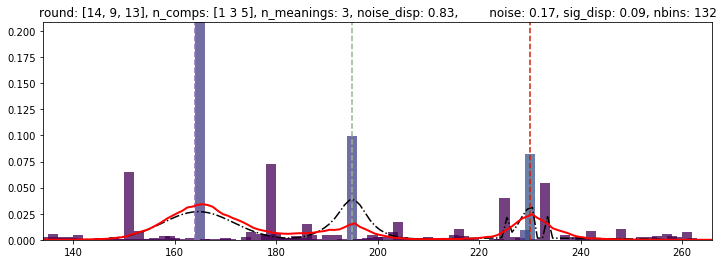

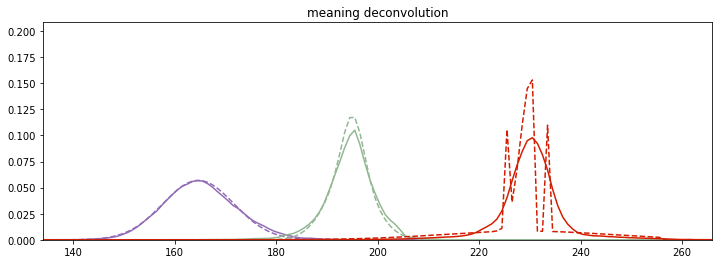

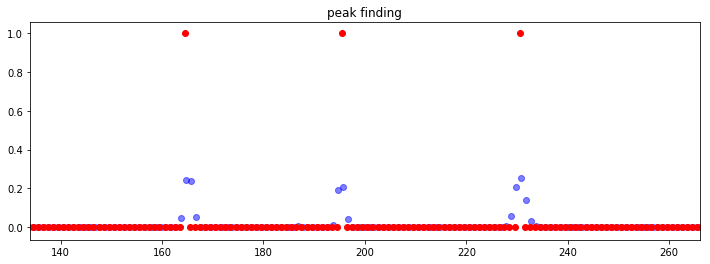

In [27]:
def plot_test_case():
    data = generator.generate()
    n_bins_0 = data['n_bins']
    modes_onehot, meaning_wts = data['modes_onehot'], data['meaning_wts']
    meaning_modes, meaning_wts_onehot = data['meaning_modes'], data['meaning_wts_onehot']
    obs = data['obs']
    meaning_pdfs = data['meaning_pdfs']
#     print(meaning_pdfs)
    meaning_n_obs = data['meaning_n_obs']
    meaning_n_comps = data['meaning_n_comps']
    meaning_means, meaning_sigmas = data['meaning_means'], data['meaning_sigmas']
#     n_bins = data['n_bins']
    n_bins = MAXBINS
    
    h = np.arange(n_bins)
    x, smoother_input, peakinput, deconv_input, meaning_modes, meaning_pdfs, pdf, start =\
        prepare_network_input_output(data['obs'], data['pdf'], meaning_modes, meaning_pdfs)

    modes_onehot, _ = standardize_bins(modes_onehot)
    
#     print(smoother_input.shape)
#     print(deconv_input.shape)
#     print(smoother_input[:,:,2])
#     print(deconv_input[:,:,2])

    smooth, peaks = model_smoother(smoother_input)
    deconvolved = model_deconv(deconv_input)
#     smooth, peaks = model_smoother(smoother_inputs)
    smooth = np.squeeze(smooth.numpy())
    peaks = np.squeeze(peaks.numpy())
#     deconvolved = model_deconv(deconv_input)
    deconvolved = np.squeeze(deconvolved.numpy(), -1)

    
#     print(n_bins)
#     print(deconv_input.shape)
#     print(deconvolved.shape)
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.ylim(0, 25 * np.mean(x[x > 0]))
    plt.bar(h, x, width=2, alpha=0.75, color=viridis(peaks))
    plt.plot(h + 0.5, pdf, c="black", ls="-.")
    r, nc, noise_disp = data['rounding'], data['n_meanings'], data['noise_dispersion']
    N, eps, sig_disp = data['n_bins'], data['noise_ratio'], data['signal_overdispersion']

    print(list(zip(meaning_modes.astype(int), np.round(meaning_wts, 3), meaning_n_obs)))
    
    meaning_means = [[int(xi) for xi in np.round(x)] for x in meaning_means]
    meaning_sigmas = [[int(xi) for xi in np.round(x)] for x in meaning_sigmas]
    print(f"meaning_means: {meaning_means}, meaning_sigmas: {meaning_sigmas}")
    plt.title(f"round: {r}, n_comps: {meaning_n_comps}, n_meanings: {nc}, noise_disp: {noise_disp:.2f},\
        noise: {eps:.2f}, sig_disp: {sig_disp:.2f}, nbins: {N}")
    for w, d, m, c in zip(meaning_wts, meaning_pdfs, meaning_modes, cols):
#         plt.plot(h, w * d, c=c)
        plt.axvline(int(np.round(m)), c=c, ls="--")
    plt.plot(h + 0.5, smooth, c="red", lw=2)
    plt.show()
    # deconvolved
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.ylim(0, 25 * np.mean(x[x > 0]))
    for i in range(len(meaning_modes)):
        truth = meaning_pdfs[i]
        y = deconvolved[i,:]
        plt.plot(h + 0.5, truth, c=cols[i], ls="--")
        plt.plot(h + 0.5, y, c=cols[i])
    plt.title("meaning deconvolution")
    plt.show()
    # peaks
    plt.figure(figsize=(12, 4))
    plt.xlim(start, start + n_bins_0)
    plt.scatter(h + 0.75, peaks, c="blue", alpha=0.5)
    plt.scatter(h + 0.5, modes_onehot, c="red")
    plt.title("peak finding")
    plt.show()

        
plot_test_case()

sim 1/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1321, losses_deconv_av: 0.1317
[(155, 0.367, 24336), (247, 0.3, 19886), (349, 0.333, 20687)]
meaning_means: [[143, 147, 135], [239, 240, 237], [339]], meaning_sigmas: [[41, 6, 6], [16, 6, 6], [27]]


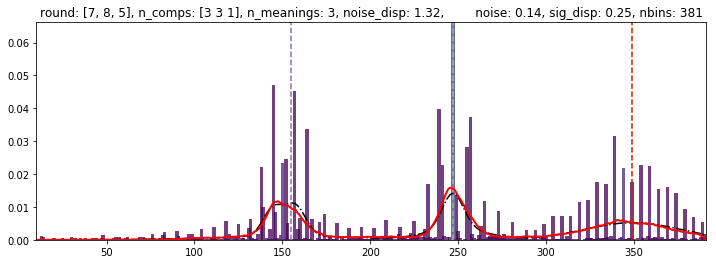

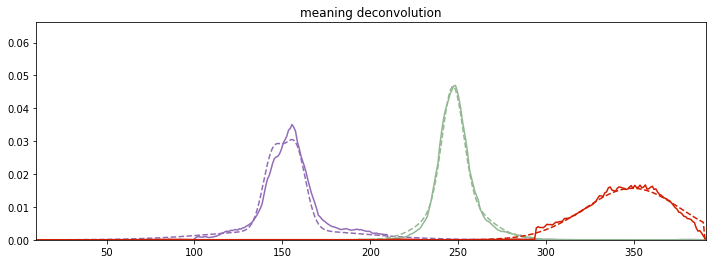

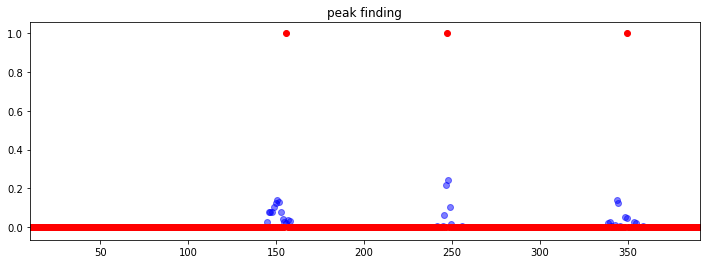

sim 10/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1359, losses_deconv_av: 0.1313
sim 20/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1358, losses_deconv_av: 0.1313
sim 30/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1394, losses_deconv_av: 0.1320
sim 40/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1447, losses_deconv_av: 0.1320
sim 50/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1427, losses_deconv_av: 0.1312
[(27, 0.59, 19486), (148, 0.41, 20018)]
meaning_means: [[5, 10, -2, 3], [130, 129]], meaning_sigmas: [[36, 8, 8, 8], [6, 8]]


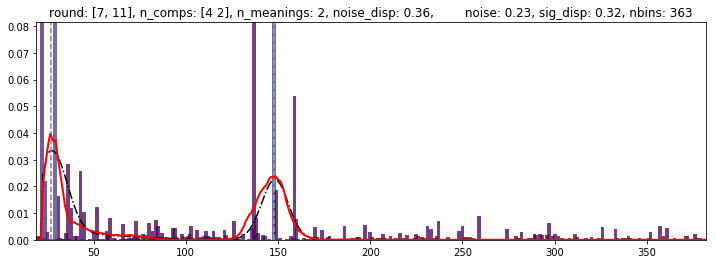

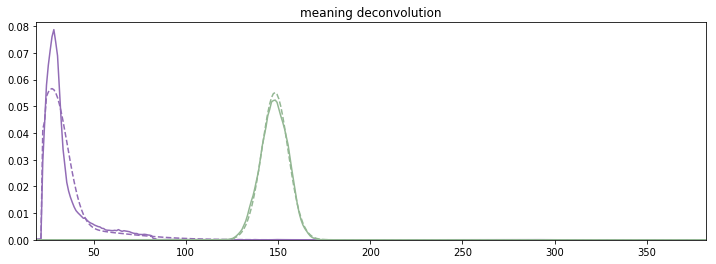

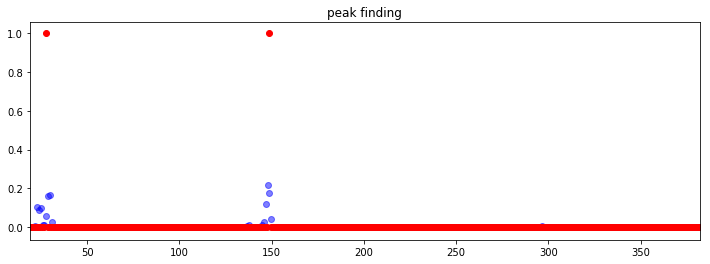

sim 60/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1450, losses_deconv_av: 0.1300
sim 70/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1420, losses_deconv_av: 0.1303
sim 80/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1426, losses_deconv_av: 0.1316
sim 90/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1403, losses_deconv_av: 0.1310
sim 100/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1425, losses_deconv_av: 0.1321
[(156, 0.174, 8881), (237, 0.826, 42060)]
meaning_means: [[61, 59, 63], [139, 134, 144, 144]], meaning_sigmas: [[12, 4, 4], [27, 4, 4, 4]]


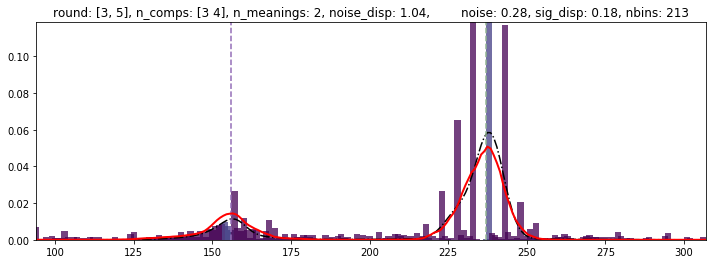

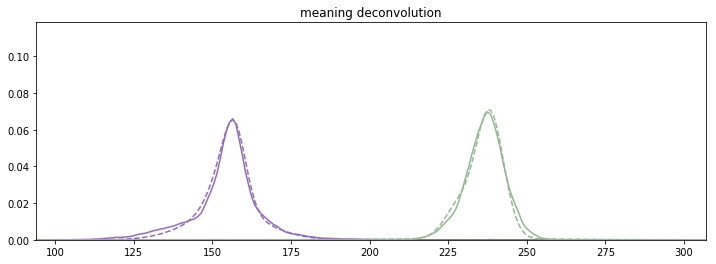

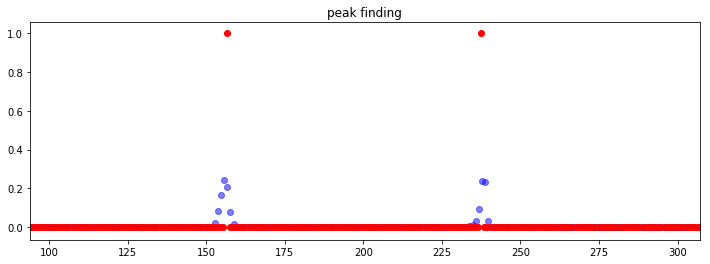

sim 110/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1406, losses_deconv_av: 0.1331
sim 120/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1385, losses_deconv_av: 0.1321
sim 130/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1363, losses_deconv_av: 0.1330
sim 140/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1351, losses_deconv_av: 0.1326
sim 150/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1338, losses_deconv_av: 0.1331
[(191, 1.0, 10890)]
meaning_means: [[76, 76, 73, 77, 76]], meaning_sigmas: [[21, 5, 5, 4, 3]]


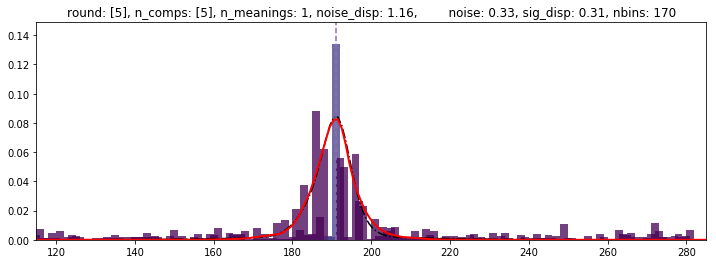

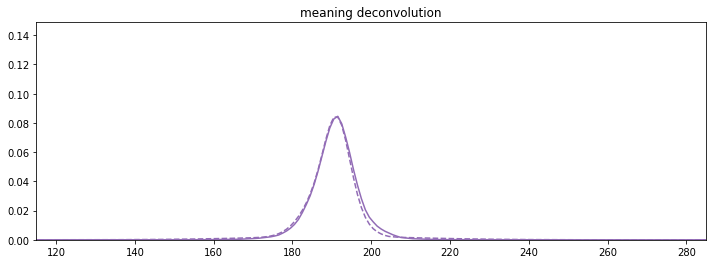

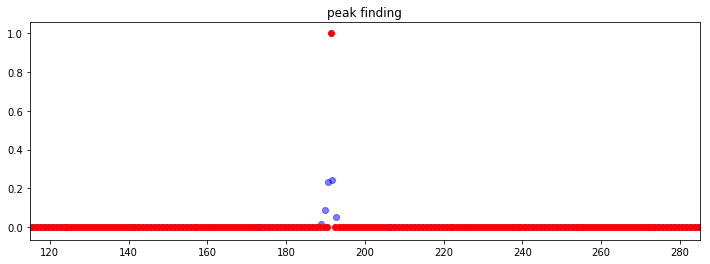

sim 160/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1351, losses_deconv_av: 0.1332
sim 170/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1353, losses_deconv_av: 0.1324
sim 180/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1353, losses_deconv_av: 0.1329
sim 190/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1345, losses_deconv_av: 0.1336
sim 200/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1341, losses_deconv_av: 0.1341
[(133, 0.266, 13318), (185, 0.288, 11130), (234, 0.446, 22359)]
meaning_means: [[33, 34, 32, 32], [84, 85, 83], [133]], meaning_sigmas: [[6, 3, 3, 3], [4, 3, 3], [11]]


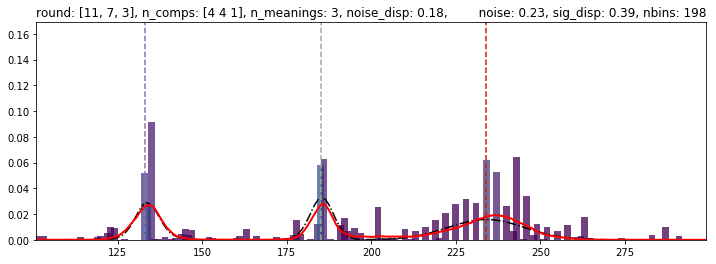

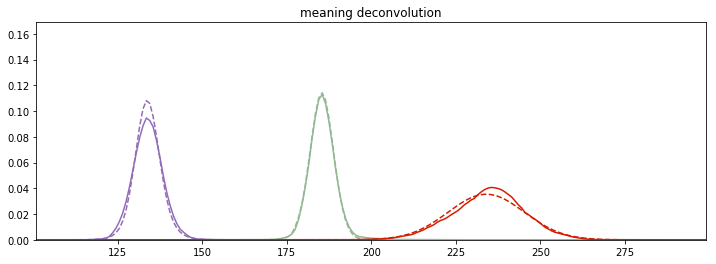

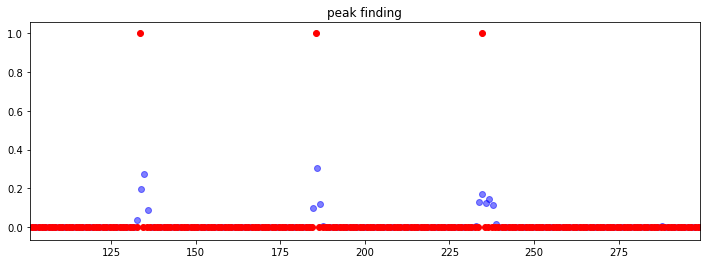

sim 210/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1338, losses_deconv_av: 0.1325
sim 220/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1384, losses_deconv_av: 0.1326
sim 230/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1360, losses_deconv_av: 0.1318
sim 240/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1354, losses_deconv_av: 0.1328
sim 250/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1346, losses_deconv_av: 0.1320
[(198, 0.103, 86), (272, 0.589, 803), (348, 0.308, 215)]
meaning_means: [[151, 151, 149], [224], [299, 300, 300]], meaning_sigmas: [[11, 5, 5], [4], [6, 5, 5]]


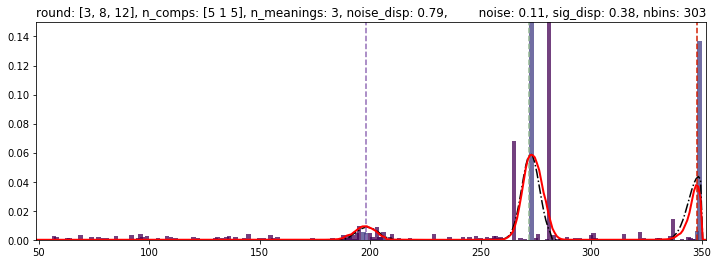

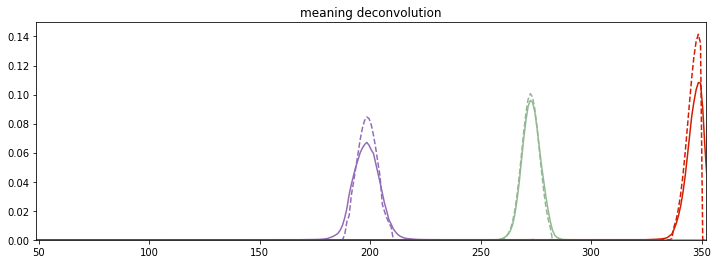

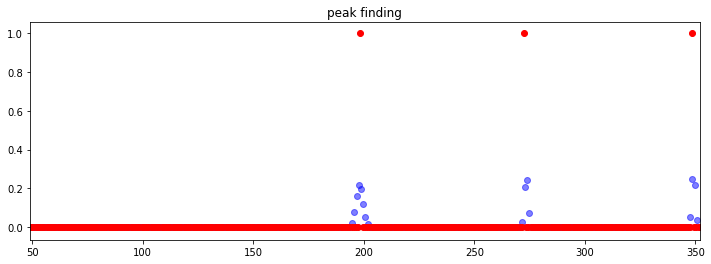

sim 260/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1366, losses_deconv_av: 0.1333
sim 270/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1339, losses_deconv_av: 0.1321
sim 280/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1345, losses_deconv_av: 0.1309
sim 290/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1340, losses_deconv_av: 0.1314
sim 300/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1321, losses_deconv_av: 0.1313
[(108, 0.175, 1607), (177, 0.302, 2785), (216, 0.127, 1173), (284, 0.395, 3053)]
meaning_means: [[52], [115, 113, 121, 122, 121], [168, 161, 172, 173, 173], [228, 229, 230, 228]], meaning_sigmas: [[20], [31, 4, 4, 4, 4], [36, 4, 4, 4, 4], [8, 4, 4, 2]]


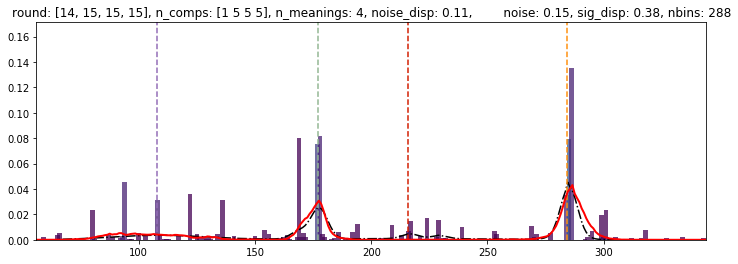

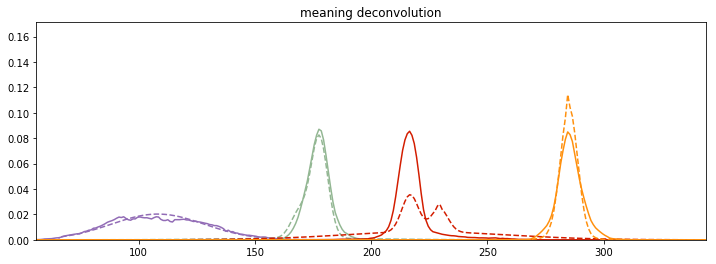

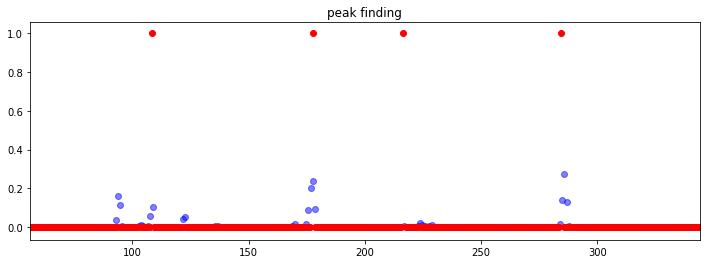

sim 310/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1305, losses_deconv_av: 0.1311
sim 320/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1300, losses_deconv_av: 0.1299
sim 330/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1290, losses_deconv_av: 0.1295
sim 340/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1306, losses_deconv_av: 0.1298
sim 350/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1302, losses_deconv_av: 0.1301
[(162, 1.0, 29609)]
meaning_means: [[1, 2, 0]], meaning_sigmas: [[5, 2, 2]]


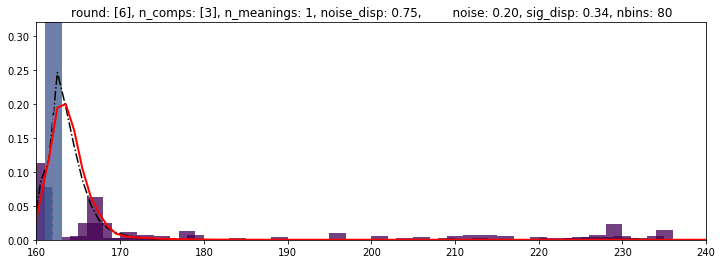

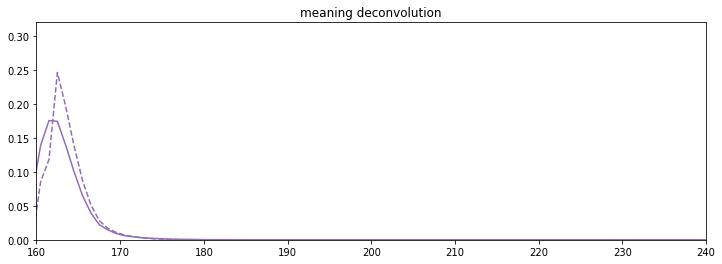

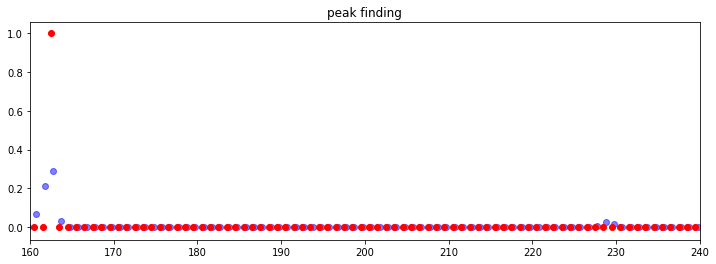

sim 360/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1298, losses_deconv_av: 0.1305
sim 370/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1304, losses_deconv_av: 0.1295
sim 380/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1308, losses_deconv_av: 0.1293
sim 390/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1327, losses_deconv_av: 0.1303
sim 400/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1370, losses_deconv_av: 0.1310
[(38, 1.0, 20243)]
meaning_means: [[19]], meaning_sigmas: [[7]]


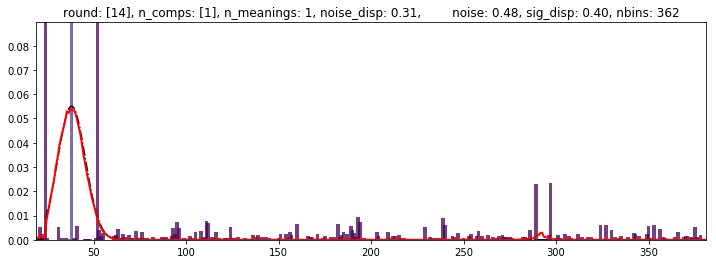

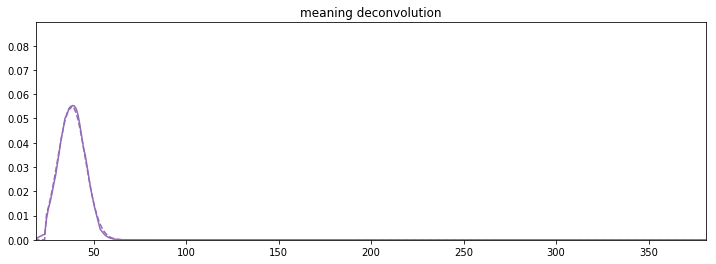

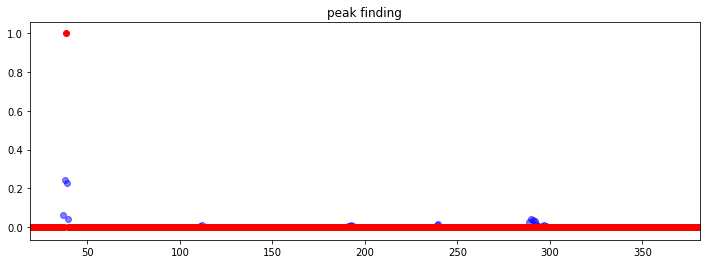

sim 410/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1391, losses_deconv_av: 0.1309
sim 420/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1406, losses_deconv_av: 0.1322
sim 430/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1395, losses_deconv_av: 0.1339
sim 440/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1396, losses_deconv_av: 0.1345
sim 450/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1409, losses_deconv_av: 0.1343
[(49, 0.337, 5558), (145, 0.386, 6469), (239, 0.276, 78)]
meaning_means: [[31, 30], [127], [221]], meaning_sigmas: [[14, 6], [8], [11]]


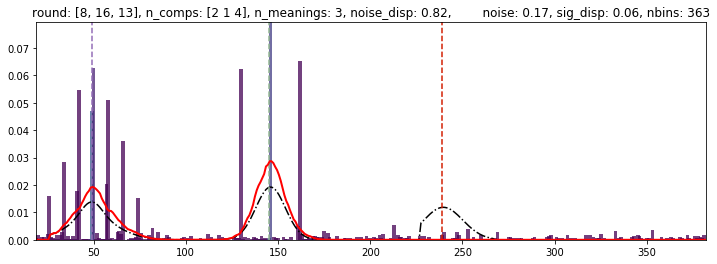

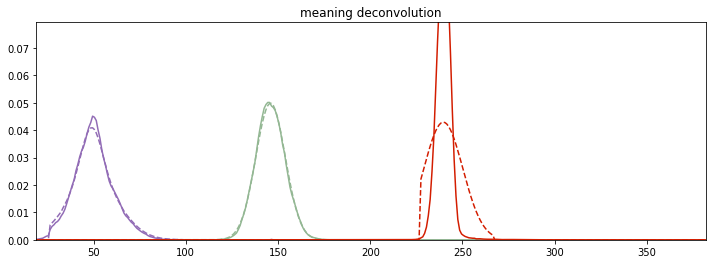

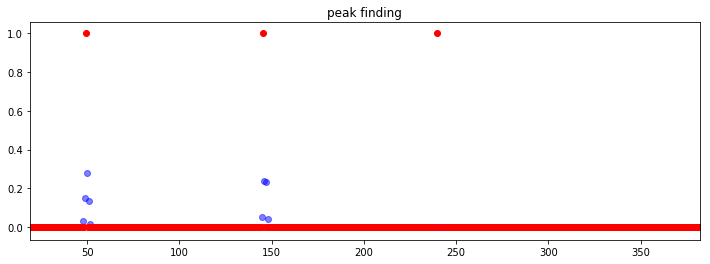

sim 460/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1429, losses_deconv_av: 0.1363
sim 470/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1409, losses_deconv_av: 0.1350
sim 480/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1414, losses_deconv_av: 0.1347
sim 490/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1415, losses_deconv_av: 0.1338
sim 500/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1385, losses_deconv_av: 0.1324


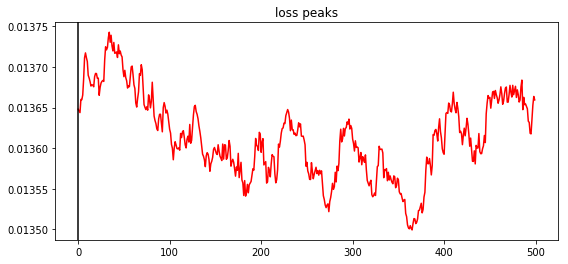

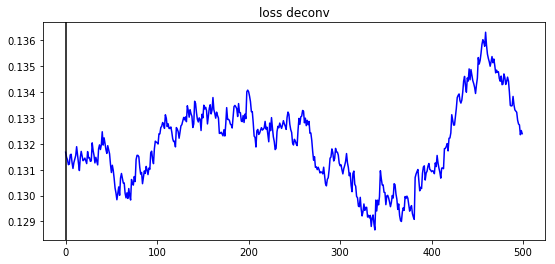

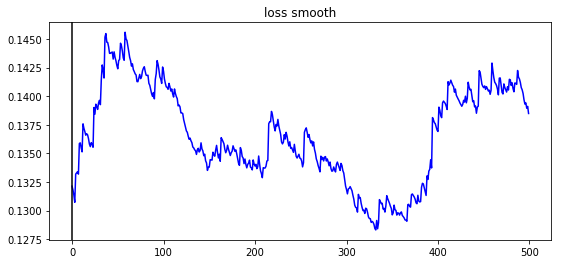

[(128, 1.0, 11506)]
meaning_means: [[45, 46]], meaning_sigmas: [[4, 6]]


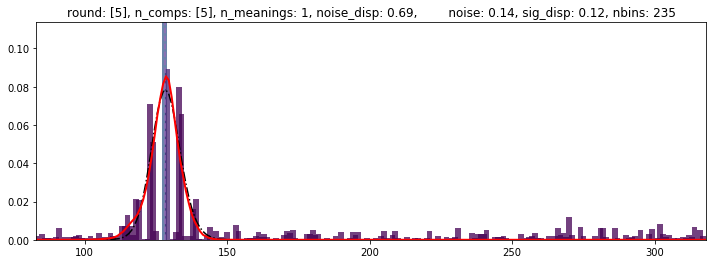

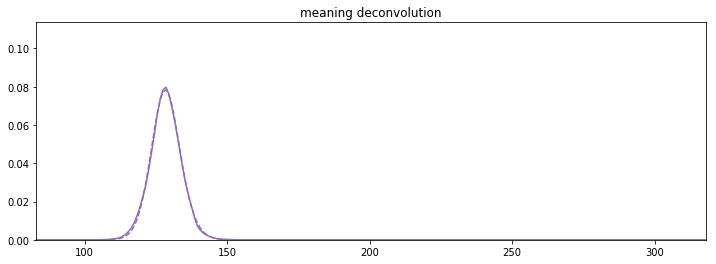

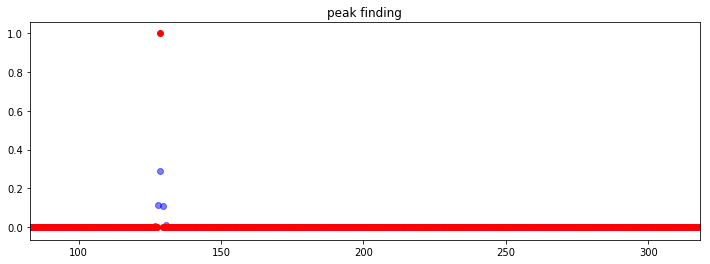

sim 510/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1360, losses_deconv_av: 0.1324
sim 520/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1371, losses_deconv_av: 0.1329
sim 530/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1359, losses_deconv_av: 0.1313
sim 540/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1340, losses_deconv_av: 0.1313
sim 550/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1342, losses_deconv_av: 0.1312
[(217, 0.108, 6215), (281, 0.892, 32687)]
meaning_means: [[115, 116, 117, 113, 116], [181, 179, 181]], meaning_sigmas: [[8, 4, 4, 4, 4], [8, 4, 4]]


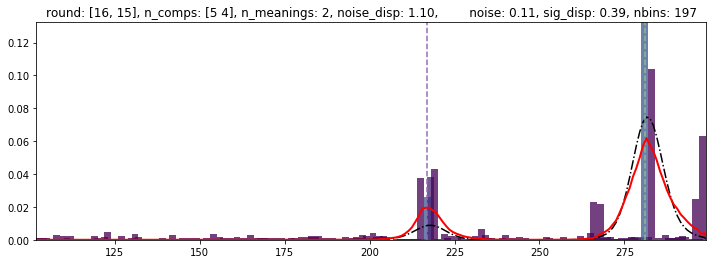

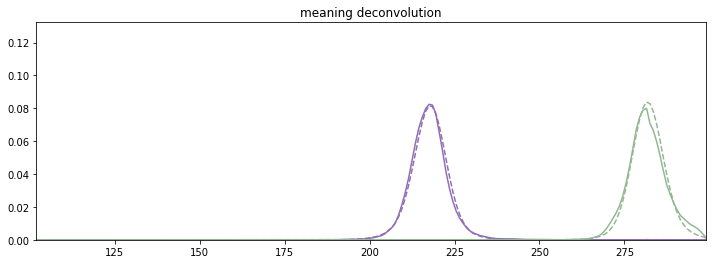

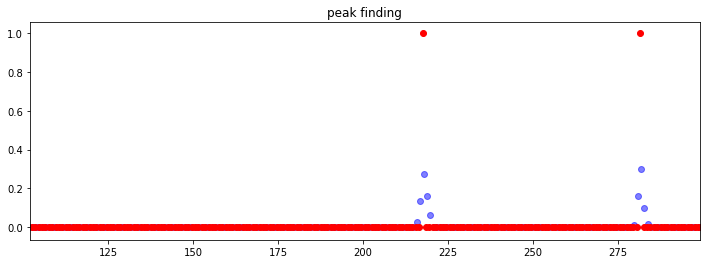

sim 560/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1391, losses_deconv_av: 0.1316
sim 570/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1385, losses_deconv_av: 0.1317
sim 580/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1371, losses_deconv_av: 0.1324
sim 590/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1391, losses_deconv_av: 0.1320
sim 600/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1374, losses_deconv_av: 0.1313
[(133, 0.103, 342), (213, 0.22, 728), (290, 0.677, 2234)]
meaning_means: [[89, 90], [170, 168, 173, 168, 169], [246, 246, 247, 245]], meaning_sigmas: [[7, 5], [16, 5, 5, 5, 3], [4, 5, 5, 5]]


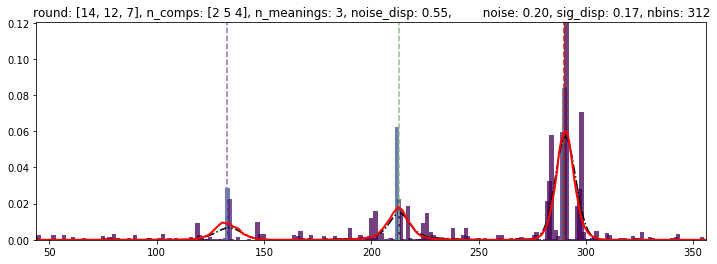

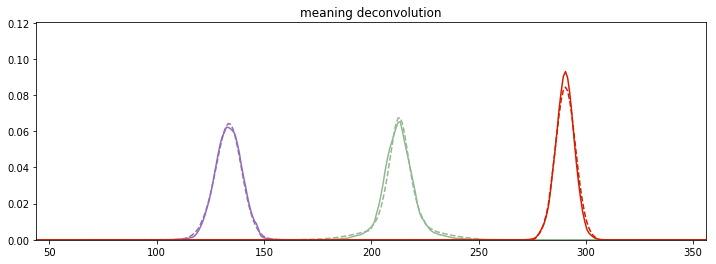

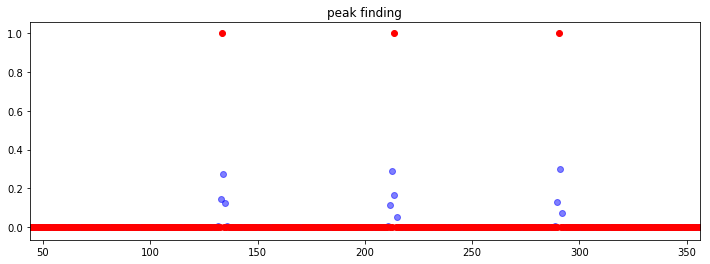

sim 610/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1355, losses_deconv_av: 0.1316
sim 620/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1344, losses_deconv_av: 0.1328
sim 630/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1349, losses_deconv_av: 0.1319
sim 640/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1341, losses_deconv_av: 0.1325
sim 650/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1343, losses_deconv_av: 0.1324
[(157, 0.414, 13487), (193, 0.458, 17981), (229, 0.128, 5029)]
meaning_means: [[28, 29], [64, 64], [101, 99, 102, 99]], meaning_sigmas: [[4, 2], [2, 1], [9, 2, 2, 2]]


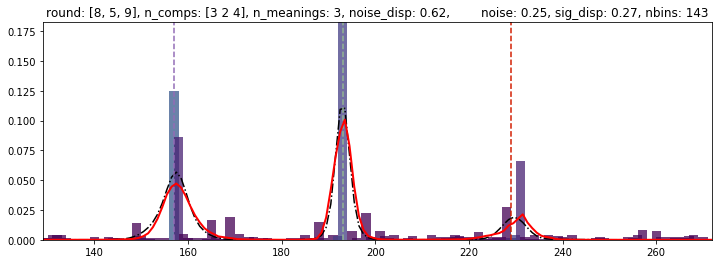

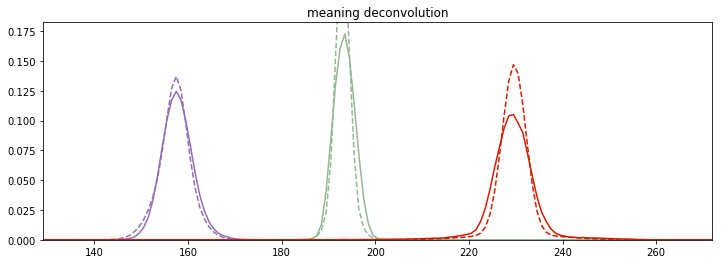

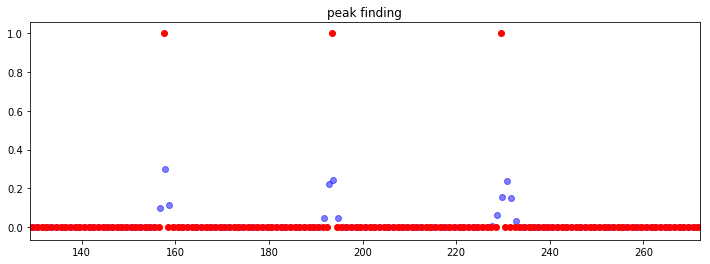

sim 660/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1322, losses_deconv_av: 0.1313
sim 670/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1317, losses_deconv_av: 0.1305
sim 680/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1361, losses_deconv_av: 0.1340
sim 690/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1362, losses_deconv_av: 0.1344
sim 700/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1339, losses_deconv_av: 0.1352
[(138, 0.337, 22108), (194, 0.375, 25808), (242, 0.288, 19848)]
meaning_means: [[40], [97, 98, 96], [146, 145]], meaning_sigmas: [[26], [8, 3, 3], [7, 3]]


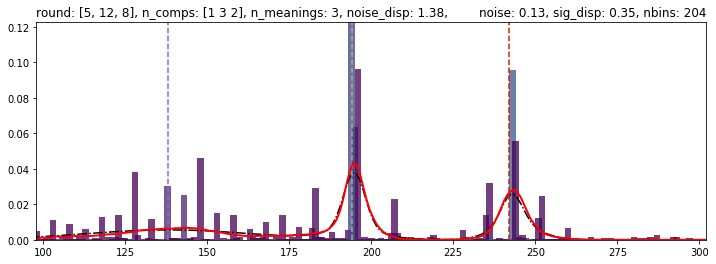

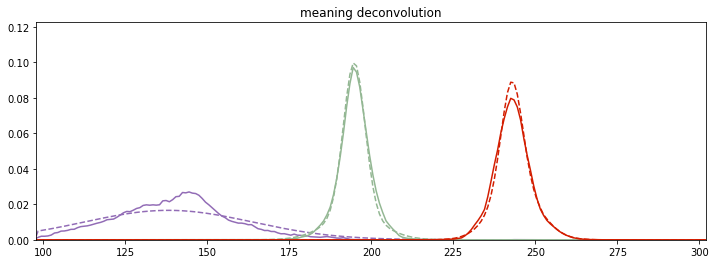

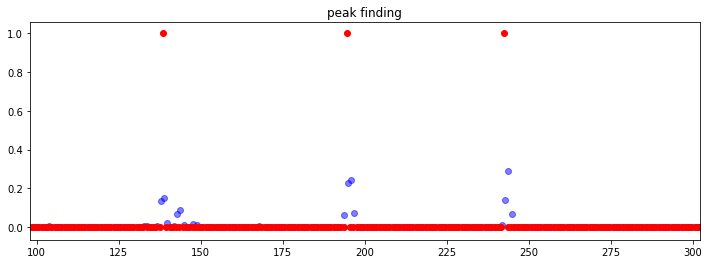

sim 710/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1353, losses_deconv_av: 0.1369
sim 720/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1377, losses_deconv_av: 0.1367
sim 730/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1385, losses_deconv_av: 0.1360
sim 740/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1359, losses_deconv_av: 0.1346
sim 750/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1348, losses_deconv_av: 0.1343
[(131, 0.107, 4658), (183, 0.586, 15564), (239, 0.118, 3894), (289, 0.19, 8241)]
meaning_means: [[62, 67, 63, 61, 62], [115, 115], [172, 172, 171, 172], [222, 222, 221]], meaning_sigmas: [[19, 3, 3, 3, 3], [6, 3], [5, 3, 3, 3], [2, 2, 3]]


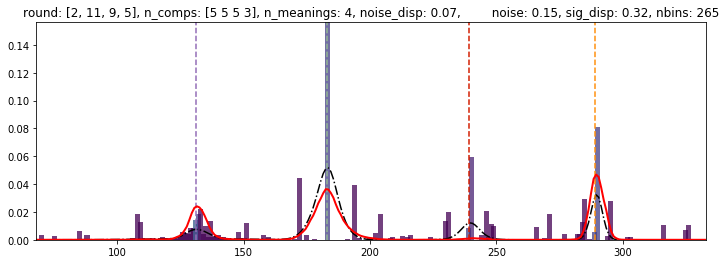

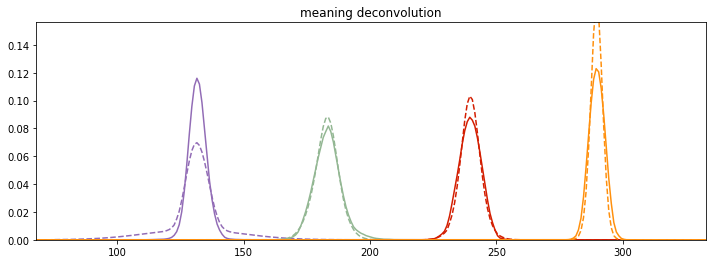

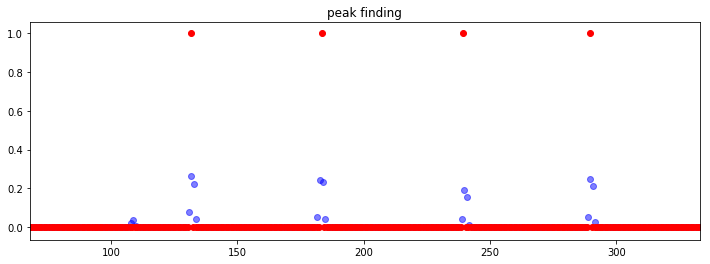

sim 760/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1366, losses_deconv_av: 0.1361
sim 770/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1351, losses_deconv_av: 0.1359
sim 780/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1330, losses_deconv_av: 0.1360
sim 790/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1328, losses_deconv_av: 0.1363
sim 800/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1353, losses_deconv_av: 0.1355
[(61, 0.161, 1100), (118, 0.252, 1040), (178, 0.294, 2297), (237, 0.293, 1138)]
meaning_means: [[9, 10], [66, 67], [128], [186, 186, 187]], meaning_sigmas: [[6, 4], [5, 4], [11], [8, 4, 4]]


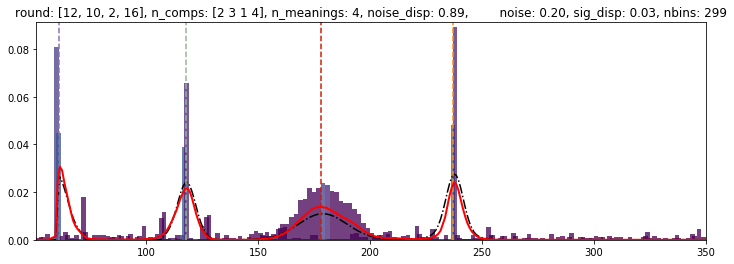

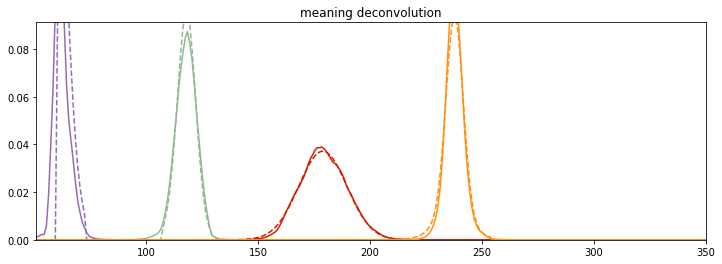

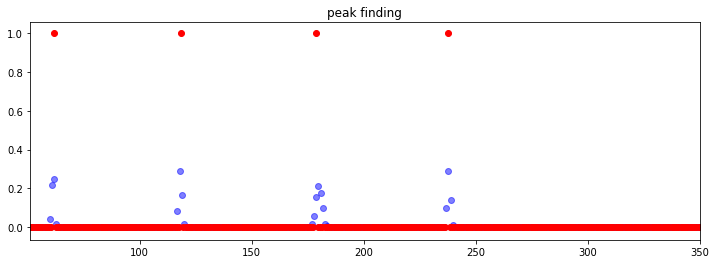

sim 810/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1337, losses_deconv_av: 0.1348
sim 820/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1312, losses_deconv_av: 0.1338
sim 830/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1303, losses_deconv_av: 0.1339
sim 840/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1302, losses_deconv_av: 0.1342
sim 850/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1285, losses_deconv_av: 0.1327
[(197, 0.54, 33931), (244, 0.117, 2708), (292, 0.344, 12803)]
meaning_means: [[96, 95, 95], [142, 143, 141], [190]], meaning_sigmas: [[6, 3, 2], [6, 3, 3], [5]]


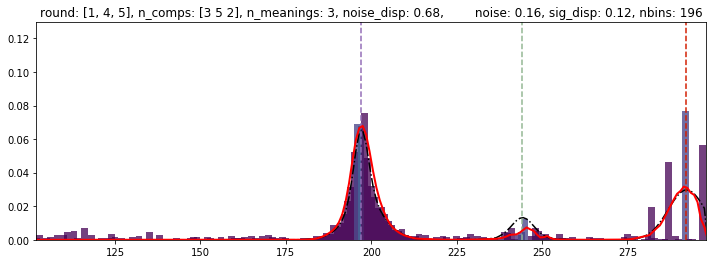

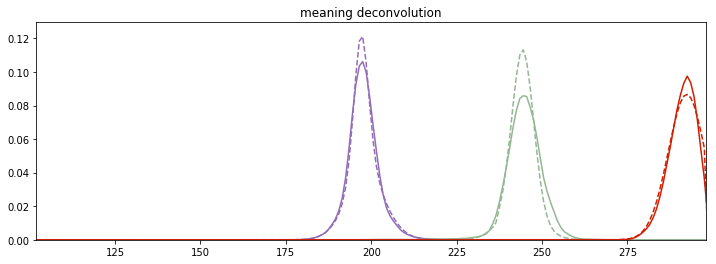

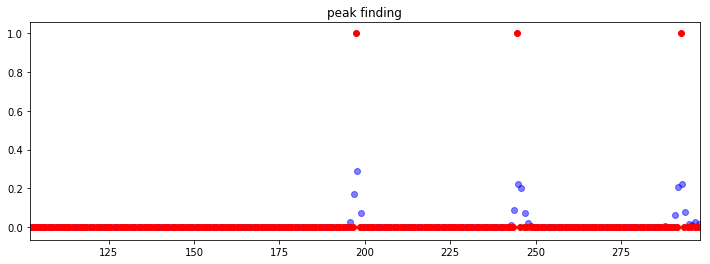

sim 860/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1279, losses_deconv_av: 0.1310
sim 870/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1266, losses_deconv_av: 0.1317
sim 880/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1296, losses_deconv_av: 0.1322
sim 890/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1304, losses_deconv_av: 0.1316
sim 900/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1303, losses_deconv_av: 0.1307
[(222, 0.349, 14027), (305, 0.651, 17801)]
meaning_means: [[134, 135, 133], [217, 216]], meaning_sigmas: [[4, 5, 5], [6, 5]]


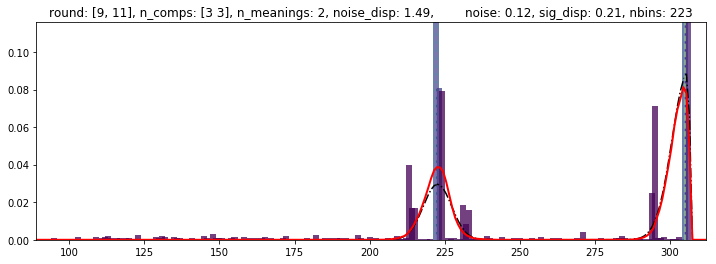

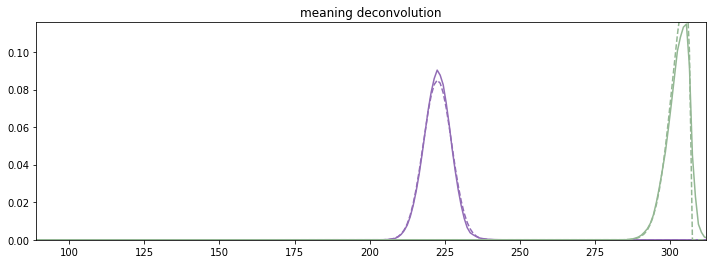

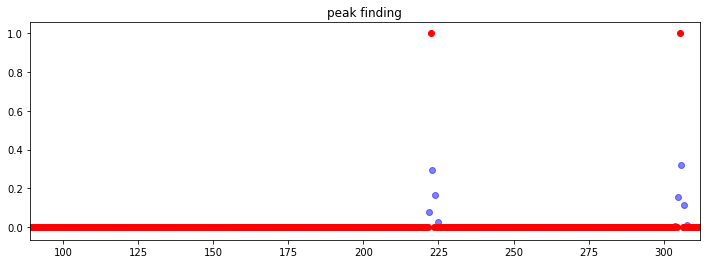

sim 910/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1295, losses_deconv_av: 0.1317
sim 920/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1299, losses_deconv_av: 0.1329
sim 930/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1301, losses_deconv_av: 0.1329
sim 940/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1292, losses_deconv_av: 0.1339
sim 950/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1286, losses_deconv_av: 0.1343
[(161, 0.596, 24256), (285, 0.404, 15511)]
meaning_means: [[147, 148, 148], [274, 273, 268]], meaning_sigmas: [[9, 8, 8], [28, 8, 8]]


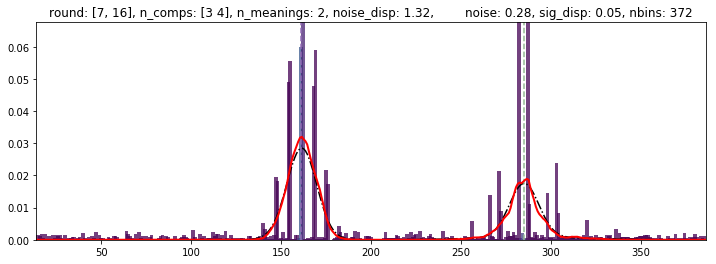

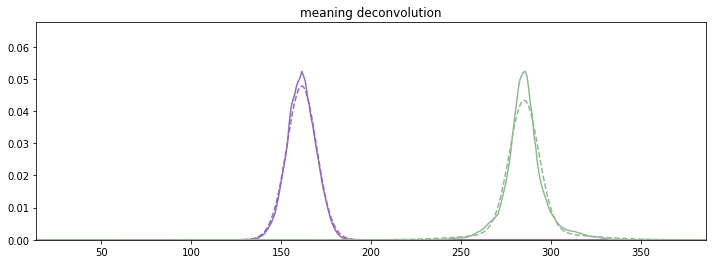

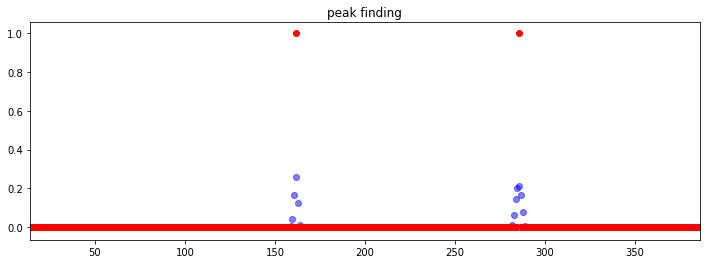

sim 960/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1299, losses_deconv_av: 0.1343
sim 970/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1284, losses_deconv_av: 0.1333
sim 980/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1266, losses_deconv_av: 0.1327
sim 990/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1293, losses_deconv_av: 0.1322
sim 1000/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1408, losses_deconv_av: 0.1337


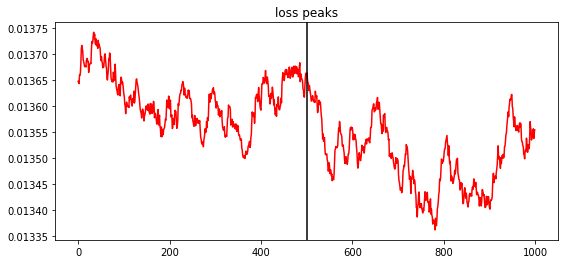

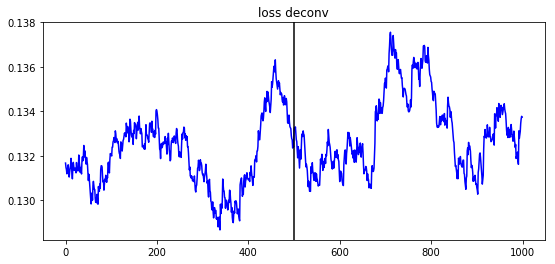

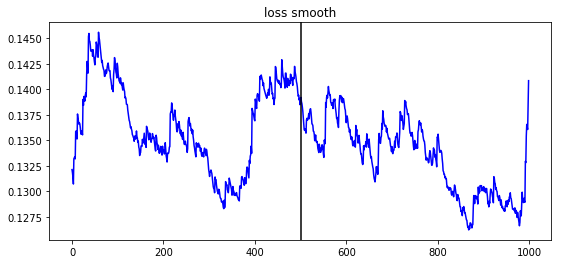

[(168, 1.0, 20232)]
meaning_means: [[9, 9, 10]], meaning_sigmas: [[8, 3, 3]]


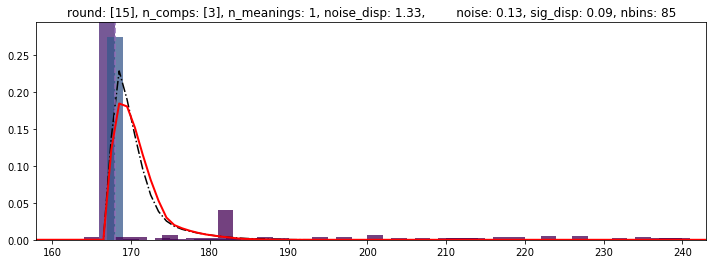

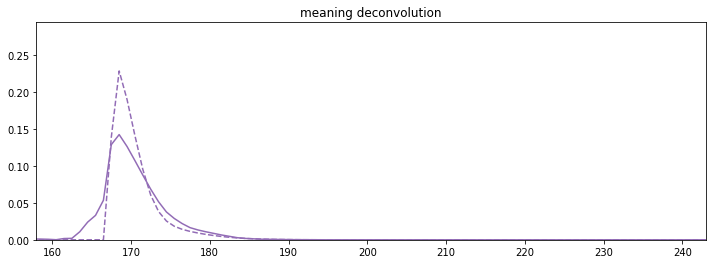

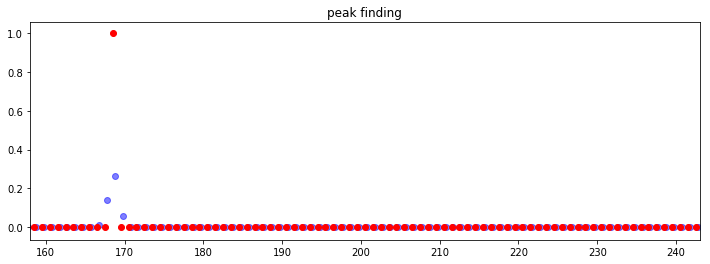

sim 1010/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1417, losses_deconv_av: 0.1346
sim 1020/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1403, losses_deconv_av: 0.1356
sim 1030/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1413, losses_deconv_av: 0.1345
sim 1040/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1374, losses_deconv_av: 0.1339
sim 1050/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1344, losses_deconv_av: 0.1330
[(181, 0.544, 23866), (203, 0.456, 20048)]
meaning_means: [[17, 15, 17, 18], [39, 38, 39, 37]], meaning_sigmas: [[9, 1, 1, 1], [9, 1, 1, 1]]


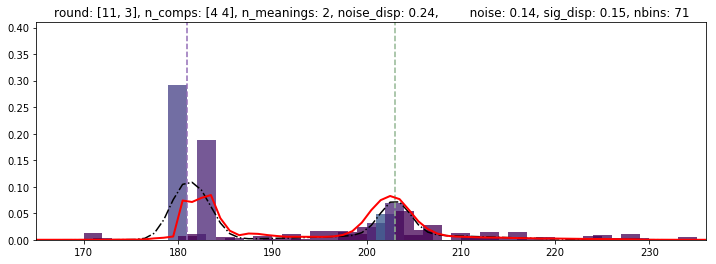

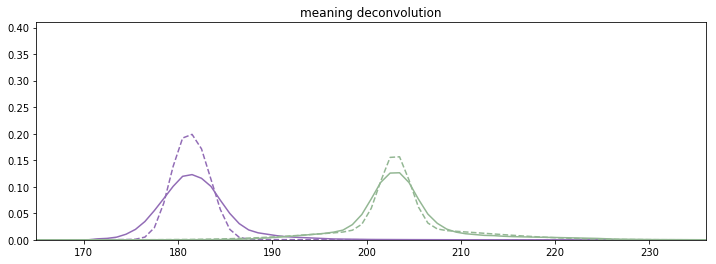

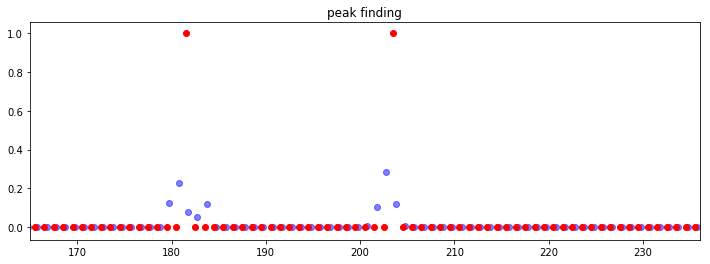

sim 1060/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1400, losses_deconv_av: 0.1337
sim 1070/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1382, losses_deconv_av: 0.1337
sim 1080/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1440, losses_deconv_av: 0.1346
sim 1090/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1407, losses_deconv_av: 0.1326
sim 1100/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1389, losses_deconv_av: 0.1331
[(181, 0.877, 47620), (309, 0.123, 1746)]
meaning_means: [[161, 162], [289, 289]], meaning_sigmas: [[4, 2], [5, 8]]


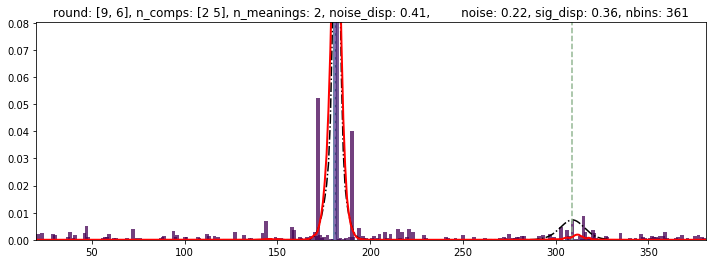

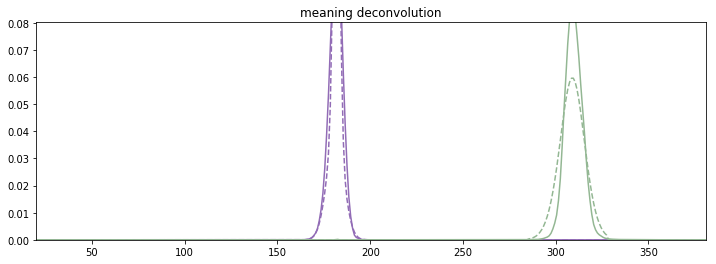

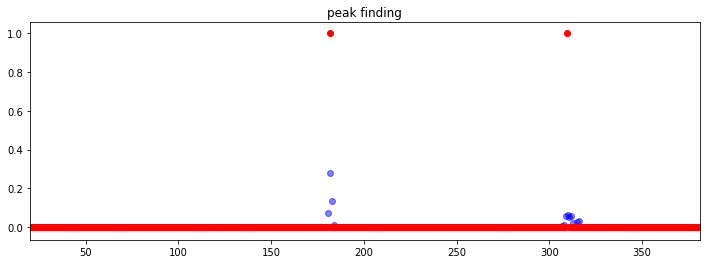

sim 1110/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1382, losses_deconv_av: 0.1319
sim 1120/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1377, losses_deconv_av: 0.1323
sim 1130/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1385, losses_deconv_av: 0.1341
sim 1140/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1373, losses_deconv_av: 0.1327
sim 1150/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1350, losses_deconv_av: 0.1320
[(136, 0.365, 23522), (221, 0.635, 25848)]
meaning_means: [[62], [146]], meaning_sigmas: [[3], [8]]


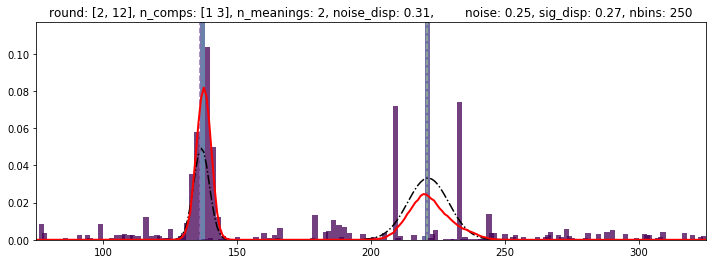

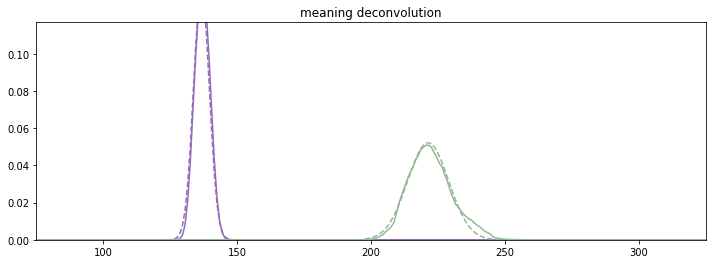

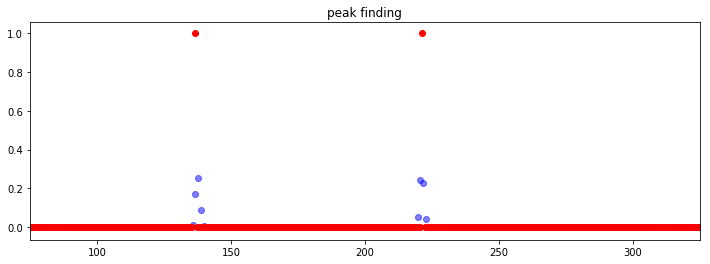

sim 1160/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1337, losses_deconv_av: 0.1335
sim 1170/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1343, losses_deconv_av: 0.1339
sim 1180/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1320, losses_deconv_av: 0.1346
sim 1190/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1308, losses_deconv_av: 0.1349
sim 1200/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1337, losses_deconv_av: 0.1362
[(175, 0.148, 147), (231, 0.852, 1714)]
meaning_means: [[57], [112, 113]], meaning_sigmas: [[6], [8, 3]]


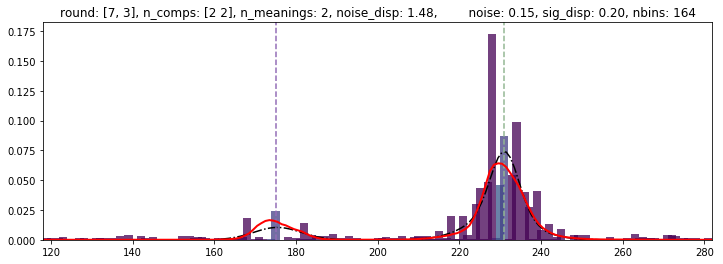

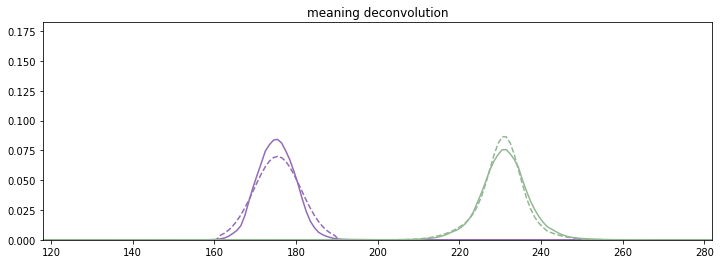

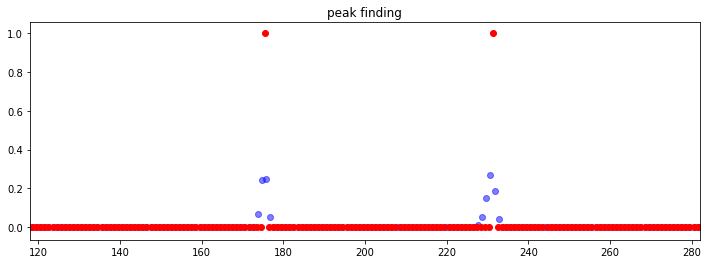

sim 1210/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1337, losses_deconv_av: 0.1369
sim 1220/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1330, losses_deconv_av: 0.1355
sim 1230/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1340, losses_deconv_av: 0.1383
sim 1240/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1339, losses_deconv_av: 0.1381
sim 1250/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1394, losses_deconv_av: 0.1374
[(244, 1.0, 6100)]
meaning_means: [[212, 205, 212, 203]], meaning_sigmas: [[40, 10, 10, 10]]


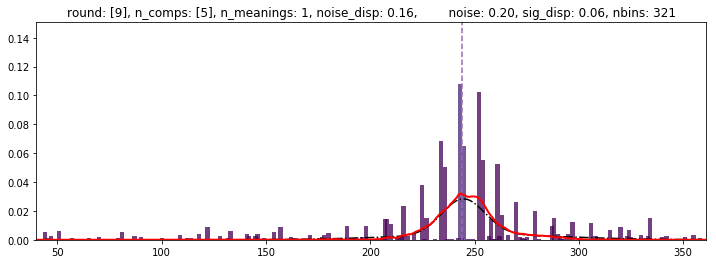

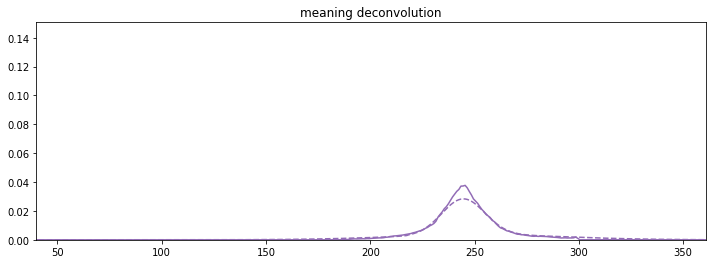

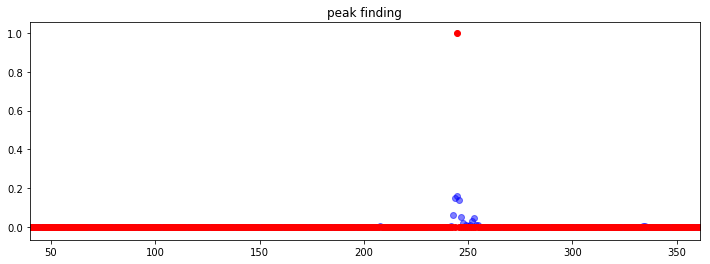

sim 1260/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1369, losses_deconv_av: 0.1382
sim 1270/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1399, losses_deconv_av: 0.1373
sim 1280/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1394, losses_deconv_av: 0.1376
sim 1290/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1415, losses_deconv_av: 0.1385
sim 1300/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1398, losses_deconv_av: 0.1378
[(181, 0.509, 3847), (274, 0.254, 5000), (350, 0.237, 4675)]
meaning_means: [[154], [248, 247], [324, 323, 324, 324, 323]], meaning_sigmas: [[5], [26, 5], [5, 5, 5, 3, 5]]


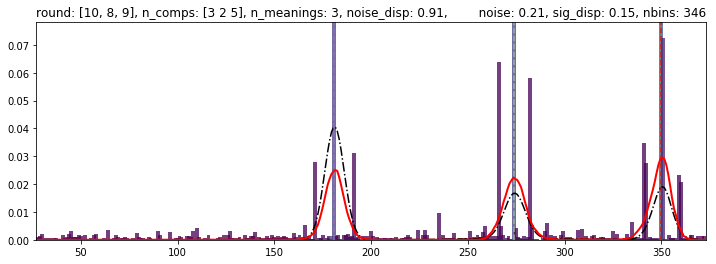

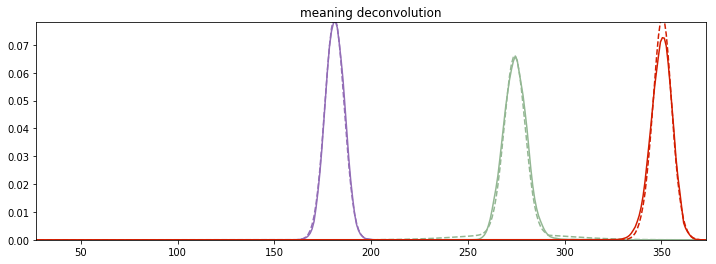

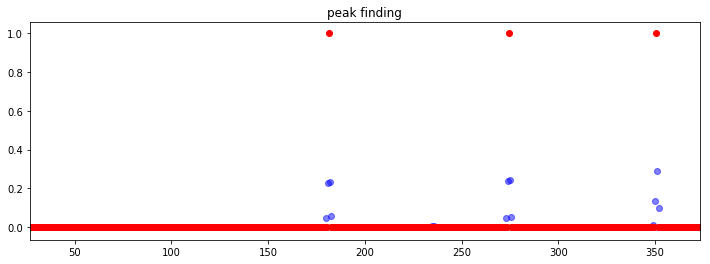

sim 1310/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1397, losses_deconv_av: 0.1365
sim 1320/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1370, losses_deconv_av: 0.1355
sim 1330/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1370, losses_deconv_av: 0.1364
sim 1340/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1362, losses_deconv_av: 0.1362
sim 1350/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1362, losses_deconv_av: 0.1375
[(130, 0.332, 16256), (173, 0.434, 18454), (214, 0.107, 5233), (259, 0.128, 6183)]
meaning_means: [[40], [83, 83, 83], [123], [171, 168, 168, 172]], meaning_sigmas: [[6], [8, 3, 3], [18], [27, 3, 3, 3]]


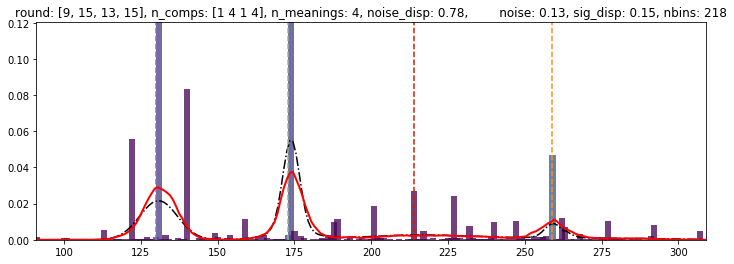

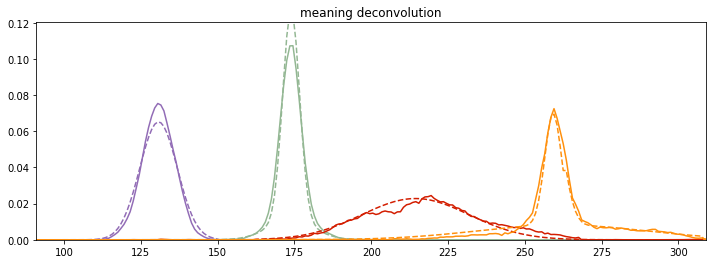

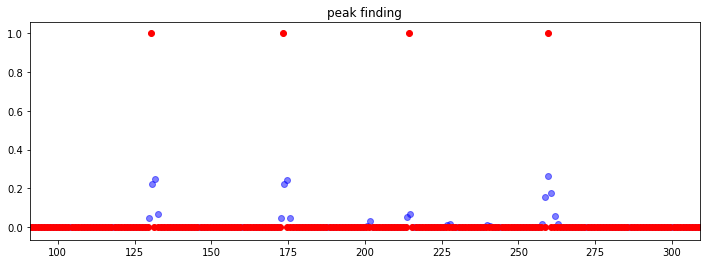

sim 1360/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1351, losses_deconv_av: 0.1365
sim 1370/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1342, losses_deconv_av: 0.1365
sim 1380/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1326, losses_deconv_av: 0.1355
sim 1390/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1359, losses_deconv_av: 0.1357
sim 1400/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1337, losses_deconv_av: 0.1346
[(242, 0.156, 1913), (354, 0.844, 13831)]
meaning_means: [[209, 209], [323, 321, 321]], meaning_sigmas: [[2, 4], [11, 4, 7]]


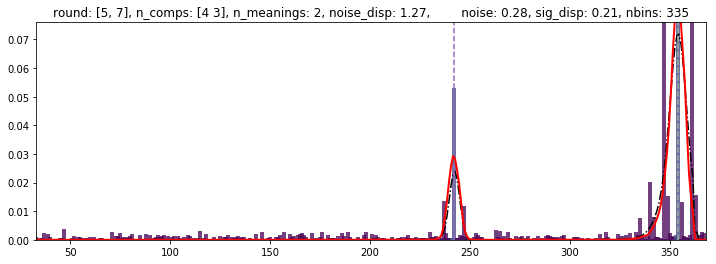

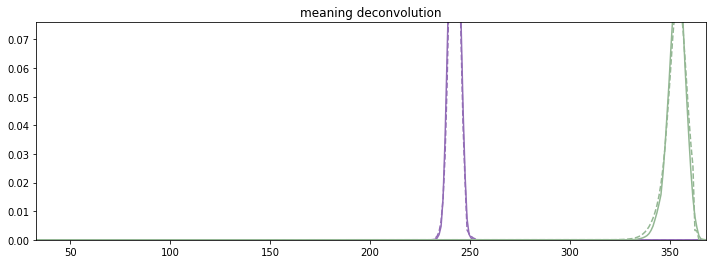

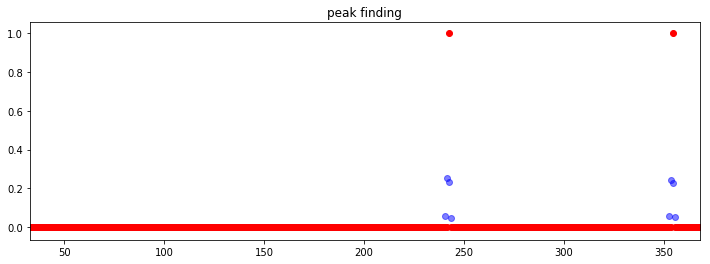

sim 1410/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1323, losses_deconv_av: 0.1335
sim 1420/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1343, losses_deconv_av: 0.1322
sim 1430/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1357, losses_deconv_av: 0.1333
sim 1440/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1335, losses_deconv_av: 0.1326
sim 1450/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1379, losses_deconv_av: 0.1333
[(190, 0.546, 45449), (227, 0.454, 37093)]
meaning_means: [[44], [81]], meaning_sigmas: [[4], [13]]


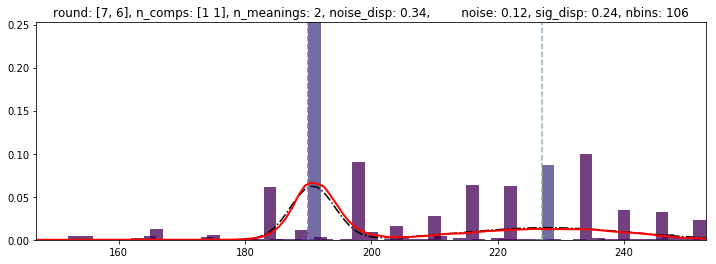

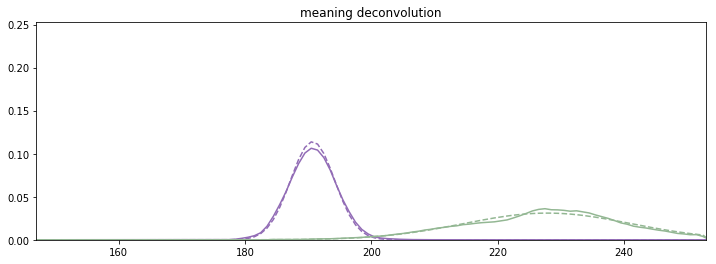

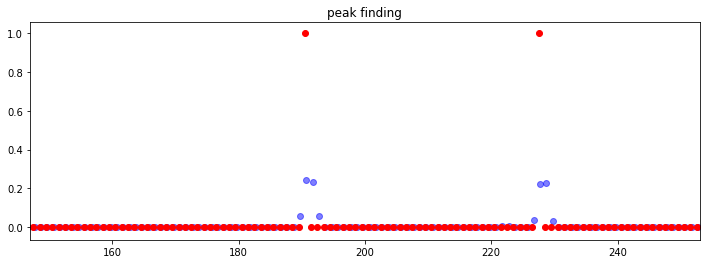

sim 1460/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1366, losses_deconv_av: 0.1331
sim 1470/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1342, losses_deconv_av: 0.1325
sim 1480/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1334, losses_deconv_av: 0.1330
sim 1490/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1384, losses_deconv_av: 0.1353
sim 1500/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1400, losses_deconv_av: 0.1347


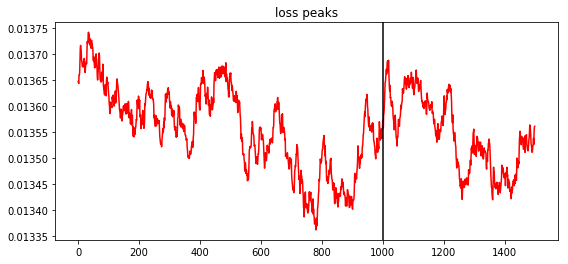

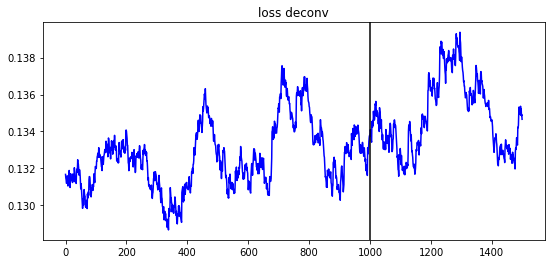

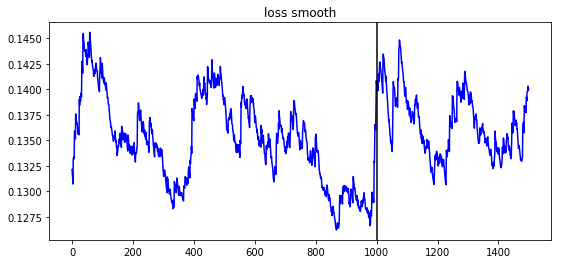

[(86, 0.341, 17837), (160, 0.481, 25413), (232, 0.179, 9439)]
meaning_means: [[26], [104, 104, 99, 108], [171, 176, 168, 172, 170]], meaning_sigmas: [[10], [22, 4, 4, 4], [18, 3, 4, 4, 4]]


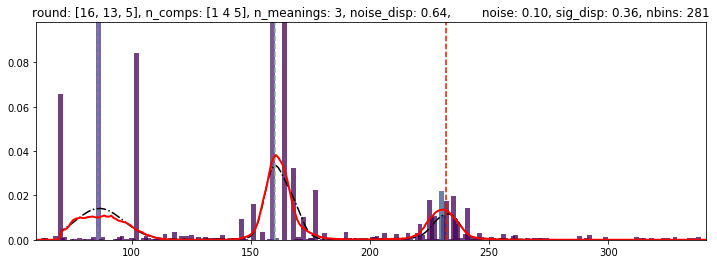

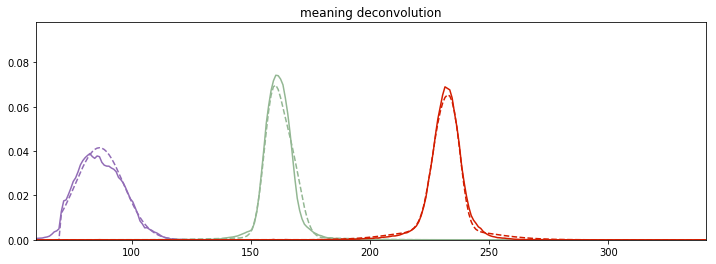

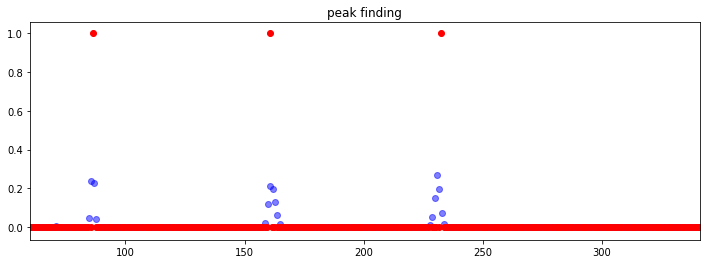

sim 1510/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1439, losses_deconv_av: 0.1344
sim 1520/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1445, losses_deconv_av: 0.1353
sim 1530/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1477, losses_deconv_av: 0.1355
sim 1540/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1472, losses_deconv_av: 0.1347
sim 1550/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1500, losses_deconv_av: 0.1337
[(164, 0.535, 12965), (215, 0.248, 6010), (252, 0.218, 5258)]
meaning_means: [[59, 59, 57], [108, 109, 109, 110, 111], [148, 144, 147, 151, 147]], meaning_sigmas: [[10, 3, 3], [15, 3, 3, 3, 3], [24, 3, 3, 3, 3]]


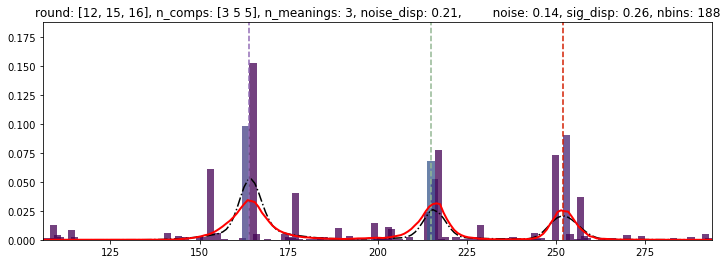

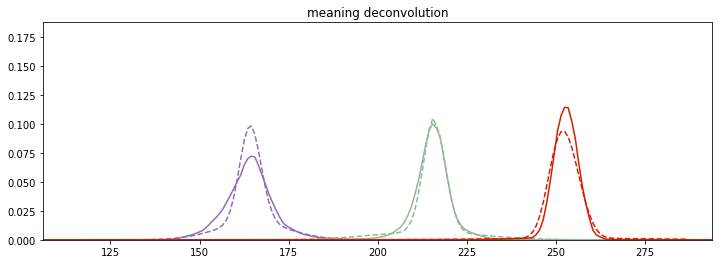

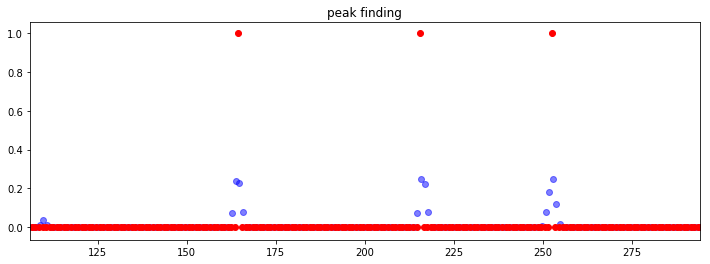

sim 1560/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1502, losses_deconv_av: 0.1344
sim 1570/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1521, losses_deconv_av: 0.1345
sim 1580/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1518, losses_deconv_av: 0.1357
sim 1590/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1523, losses_deconv_av: 0.1355
sim 1600/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1498, losses_deconv_av: 0.1370
[(125, 0.195, 2002), (184, 0.314, 3229), (236, 0.229, 2352), (295, 0.262, 2693)]
meaning_means: [[61, 60], [119, 118, 118], [171, 171, 171, 170, 170], [229, 230, 228, 229]], meaning_sigmas: [[8, 3], [9, 3, 3], [8, 3, 3, 3, 3], [8, 3, 3, 3]]


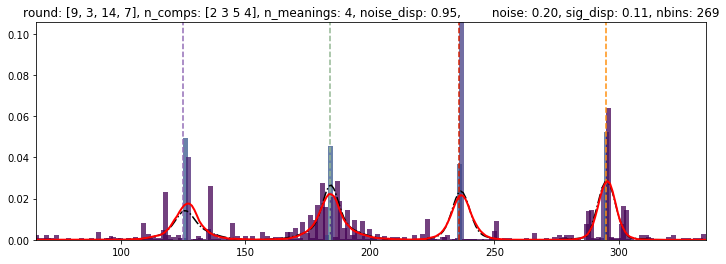

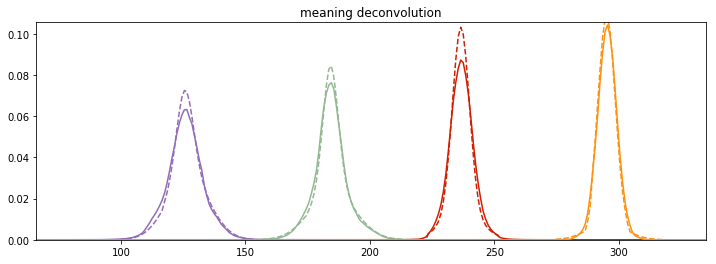

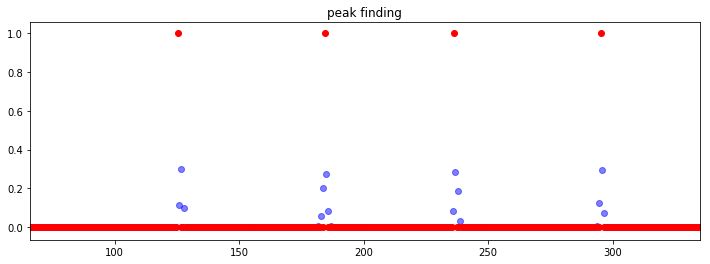

sim 1610/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1465, losses_deconv_av: 0.1347
sim 1620/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1455, losses_deconv_av: 0.1348
sim 1630/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1465, losses_deconv_av: 0.1342
sim 1640/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1511, losses_deconv_av: 0.1359
sim 1650/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1509, losses_deconv_av: 0.1365
[(154, 0.504, 4495), (201, 0.496, 3601)]
meaning_means: [[30, 30, 30], [77, 76, 79, 78]], meaning_sigmas: [[3, 3, 3], [19, 3, 3, 3]]


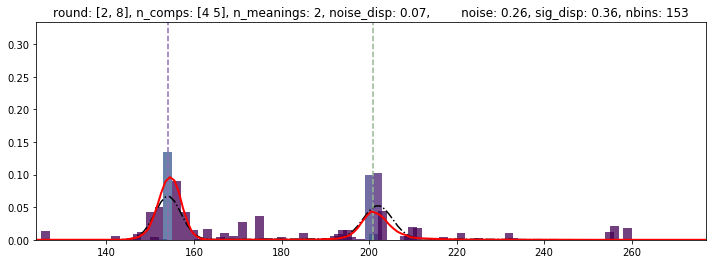

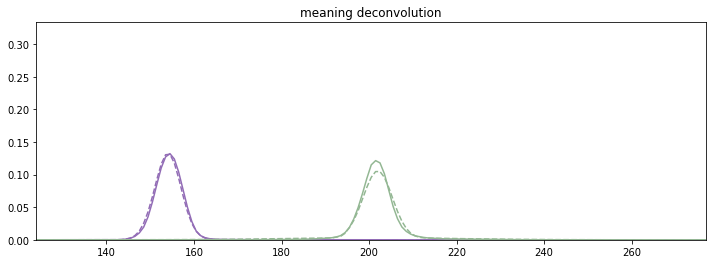

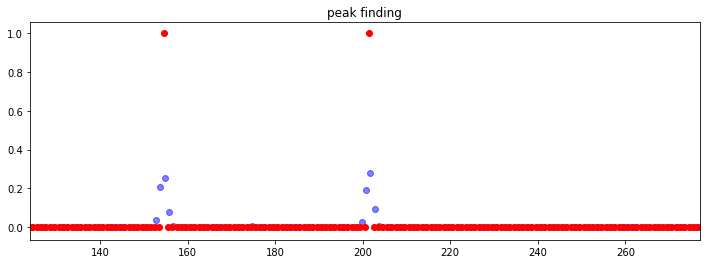

sim 1660/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1500, losses_deconv_av: 0.1363
sim 1670/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1479, losses_deconv_av: 0.1355
sim 1680/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1466, losses_deconv_av: 0.1360
sim 1690/500000 losses_peak_av: 0.0137, losses_smooth_av: 0.1430, losses_deconv_av: 0.1351
sim 1700/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1435, losses_deconv_av: 0.1345
[(76, 0.304, 12522), (161, 0.123, 3570), (242, 0.43, 10236), (317, 0.143, 5515)]
meaning_means: [[75, 75, 75], [160, 159, 161, 159], [243, 241], [315, 313, 316, 313]], meaning_sigmas: [[9, 5, 5], [6, 4, 5, 3], [12, 5], [9, 5, 3, 5]]


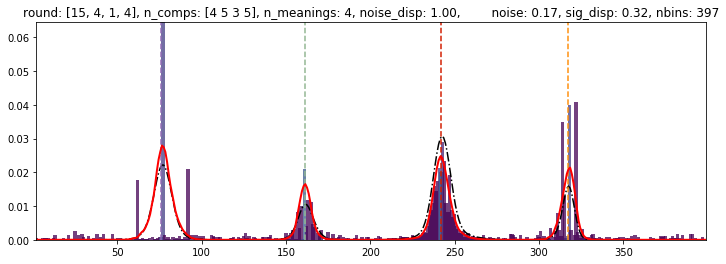

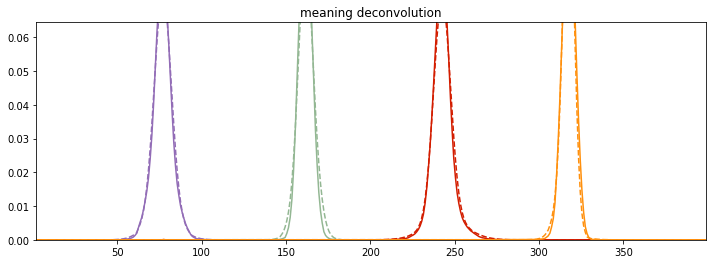

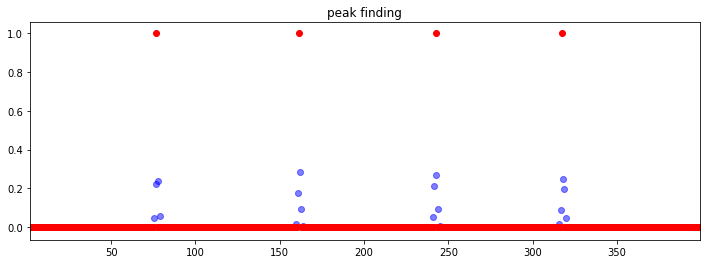

sim 1710/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1460, losses_deconv_av: 0.1357
sim 1720/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1431, losses_deconv_av: 0.1353
sim 1730/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1426, losses_deconv_av: 0.1348
sim 1740/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1417, losses_deconv_av: 0.1355
sim 1750/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1402, losses_deconv_av: 0.1331
[(104, 0.199, 15920), (148, 0.234, 20017), (192, 0.318, 27196), (242, 0.249, 21253)]
meaning_means: [[15, 19], [64, 65, 60], [106, 107, 108], [158, 157]], meaning_sigmas: [[29, 3], [19, 3, 3], [7, 3, 3], [4, 3]]


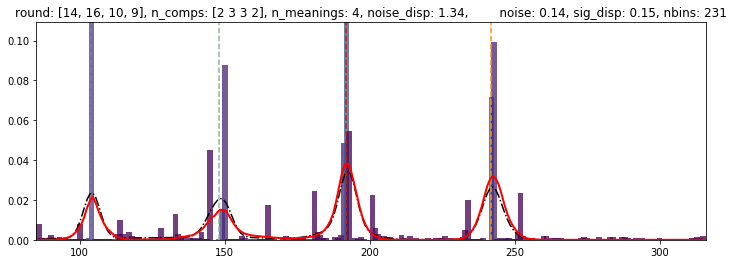

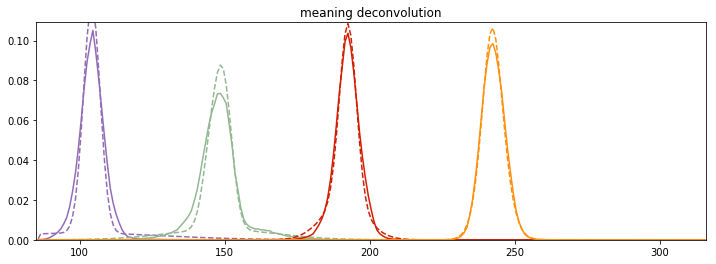

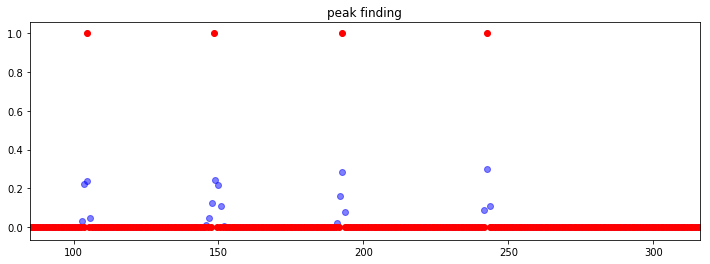

sim 1760/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1396, losses_deconv_av: 0.1326
sim 1770/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1389, losses_deconv_av: 0.1337
sim 1780/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1361, losses_deconv_av: 0.1332
sim 1790/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1389, losses_deconv_av: 0.1331
sim 1800/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1413, losses_deconv_av: 0.1319
[(200, 1.0, 15062)]
meaning_means: [[114, 116, 112]], meaning_sigmas: [[12, 7, 7]]


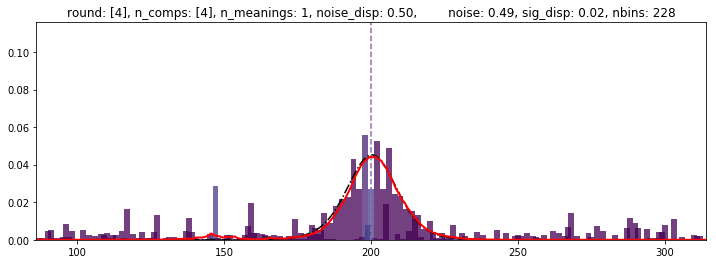

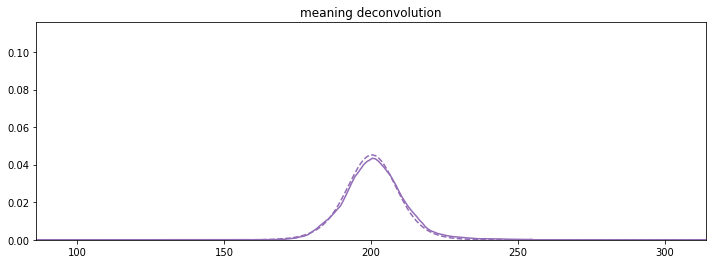

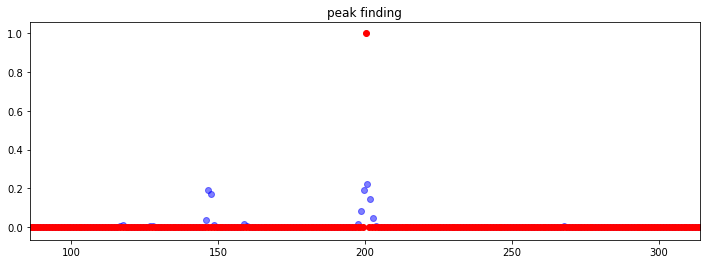

sim 1810/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1399, losses_deconv_av: 0.1321
sim 1820/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1401, losses_deconv_av: 0.1318
sim 1830/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1388, losses_deconv_av: 0.1318
sim 1840/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1390, losses_deconv_av: 0.1323
sim 1850/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1375, losses_deconv_av: 0.1312
[(205, 0.423, 19913), (223, 0.577, 26026)]
meaning_means: [[30, 31, 30, 30, 31], [49, 49, 48, 50, 48]], meaning_sigmas: [[3, 1, 1, 1, 1], [5, 1, 1, 1, 1]]


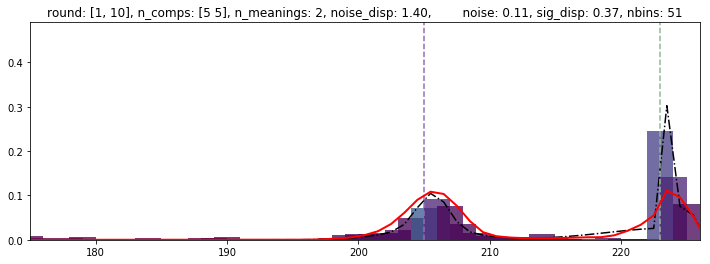

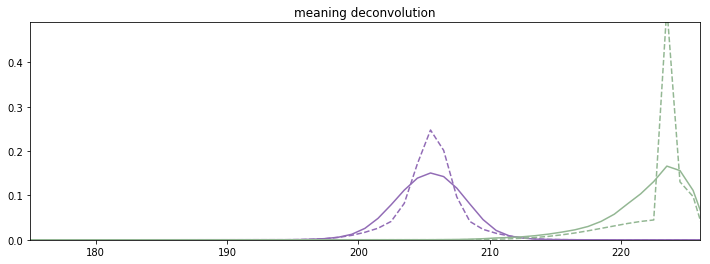

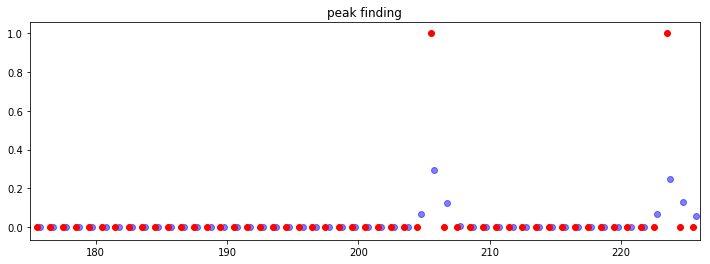

sim 1860/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1406, losses_deconv_av: 0.1309
sim 1870/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1387, losses_deconv_av: 0.1296
sim 1880/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1384, losses_deconv_av: 0.1294
sim 1890/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1369, losses_deconv_av: 0.1297
sim 1900/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1383, losses_deconv_av: 0.1302
[(185, 1.0, 37905)]
meaning_means: [[40]], meaning_sigmas: [[6]]


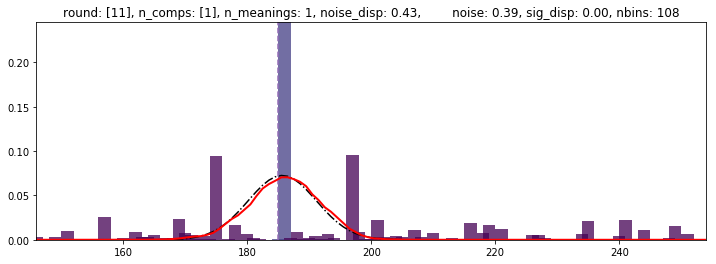

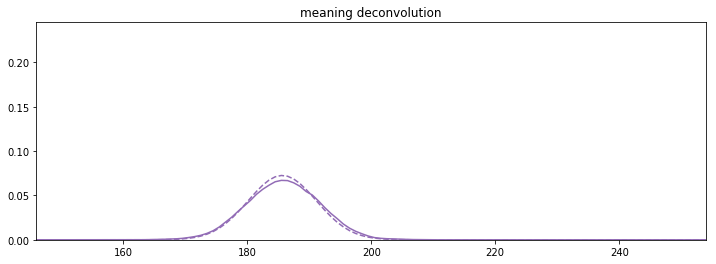

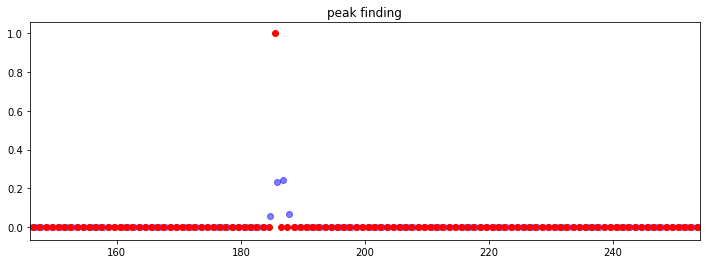

sim 1910/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1405, losses_deconv_av: 0.1305
sim 1920/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1427, losses_deconv_av: 0.1309
sim 1930/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1405, losses_deconv_av: 0.1308
sim 1940/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1391, losses_deconv_av: 0.1302
sim 1950/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1410, losses_deconv_av: 0.1312
[(116, 0.562, 13525), (186, 0.224, 5386), (266, 0.103, 2471), (333, 0.112, 2687)]
meaning_means: [[100, 101, 101], [172], [252], [318]], meaning_sigmas: [[22, 5, 5], [4], [3], [8]]


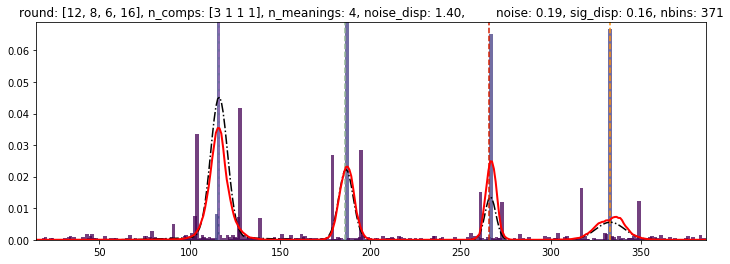

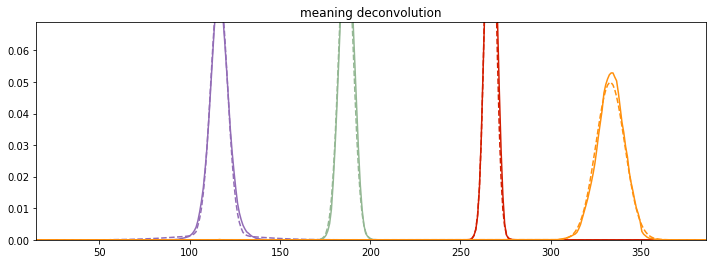

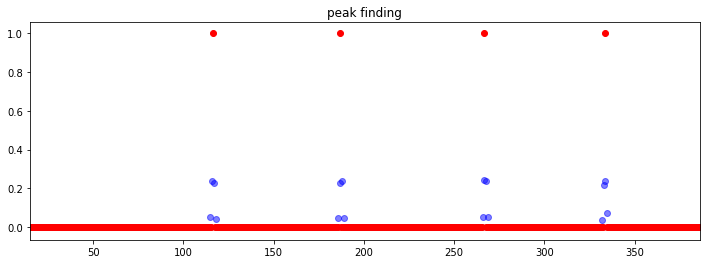

sim 1960/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1389, losses_deconv_av: 0.1318
sim 1970/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1376, losses_deconv_av: 0.1325
sim 1980/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1415, losses_deconv_av: 0.1353
sim 1990/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1417, losses_deconv_av: 0.1350
sim 2000/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1453, losses_deconv_av: 0.1351


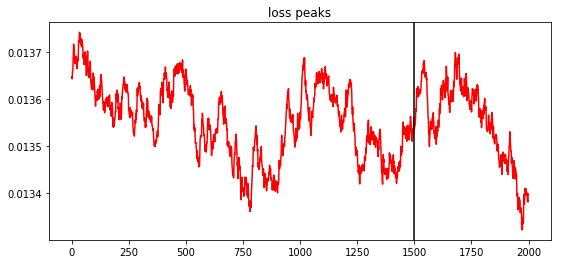

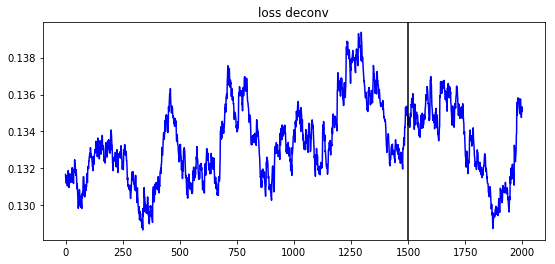

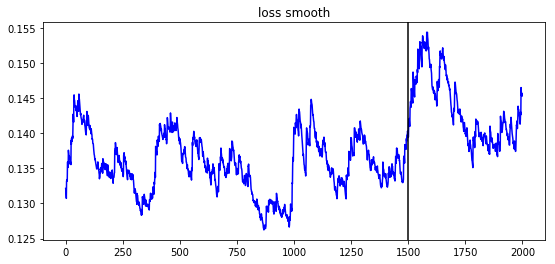

[(203, 1.0, 42973)]
meaning_means: [[71, 68, 72]], meaning_sigmas: [[16, 3, 4]]


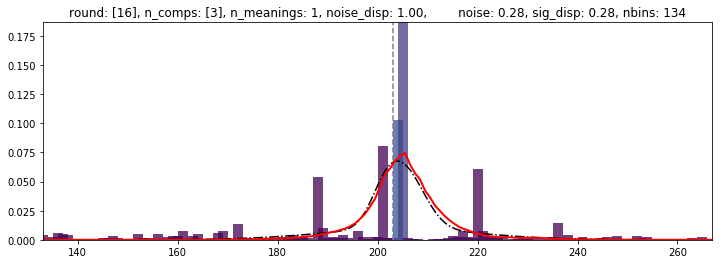

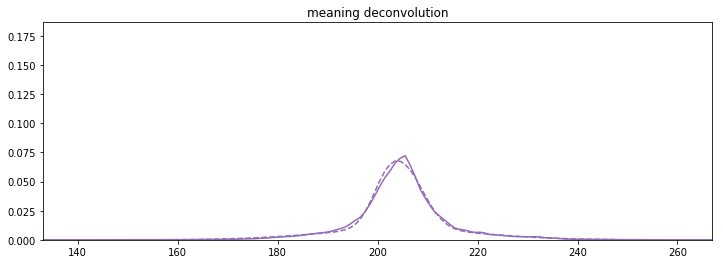

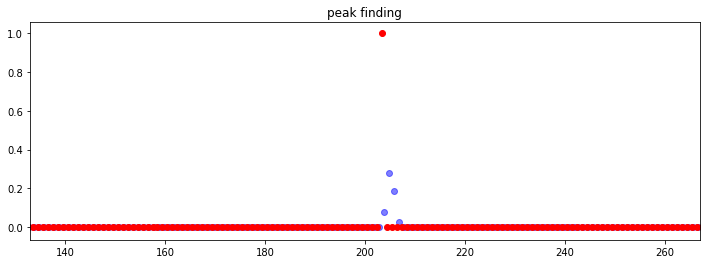

sim 2010/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1473, losses_deconv_av: 0.1345
sim 2020/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1458, losses_deconv_av: 0.1329
sim 2030/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1472, losses_deconv_av: 0.1328
sim 2040/500000 losses_peak_av: 0.0134, losses_smooth_av: 0.1448, losses_deconv_av: 0.1341
sim 2050/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1457, losses_deconv_av: 0.1339
[(162, 0.257, 5441), (196, 0.743, 13514)]
meaning_means: [[15, 17, 18, 15, 12], [51, 51, 51]], meaning_sigmas: [[14, 2, 2, 2, 2], [5, 2, 2]]


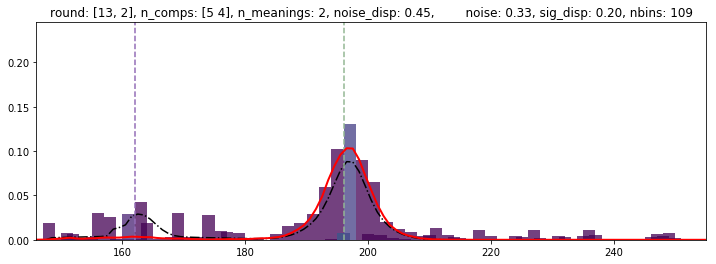

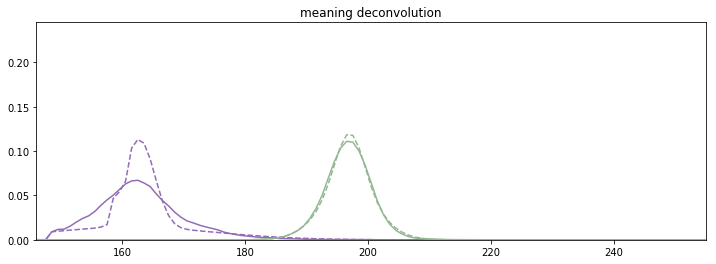

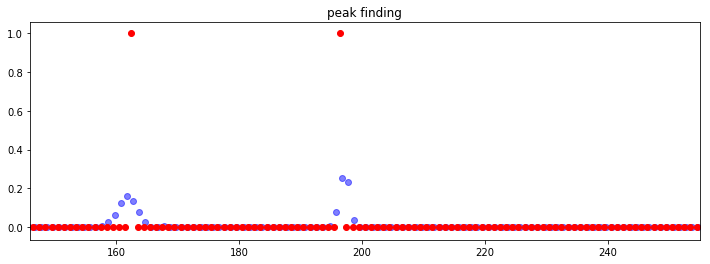

sim 2060/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1493, losses_deconv_av: 0.1331
sim 2070/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1456, losses_deconv_av: 0.1329
sim 2080/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1481, losses_deconv_av: 0.1327
sim 2090/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1470, losses_deconv_av: 0.1318
sim 2100/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1461, losses_deconv_av: 0.1326
[(151, 0.126, 7753), (209, 0.362, 8475), (270, 0.304, 15522), (331, 0.207, 10060)]
meaning_means: [[103, 104, 101], [162, 162], [222, 222, 222], [284, 284]], meaning_sigmas: [[18, 4, 4], [3, 2], [2, 4, 4], [12, 4]]


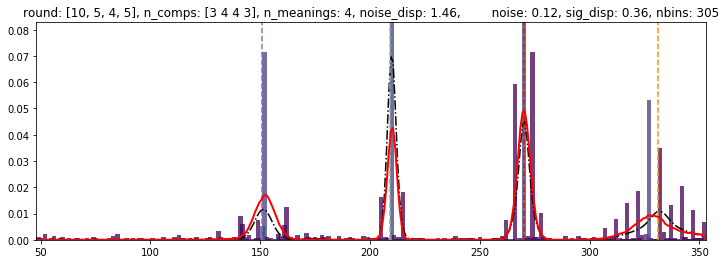

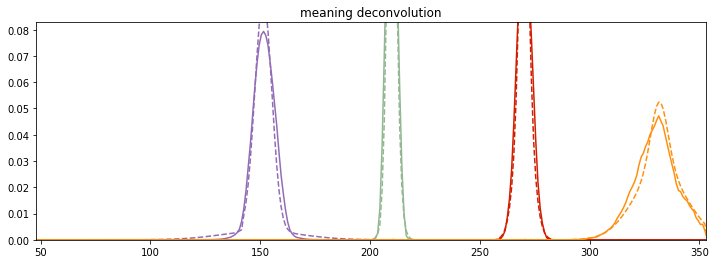

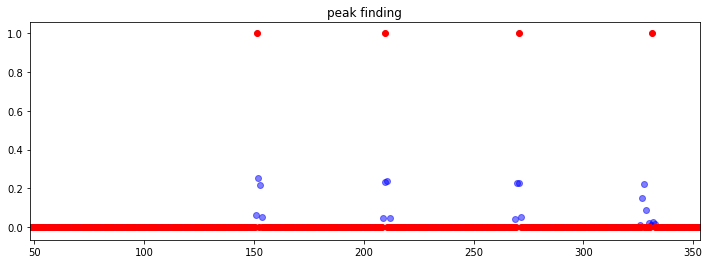

sim 2110/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1484, losses_deconv_av: 0.1323
sim 2120/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1468, losses_deconv_av: 0.1320
sim 2130/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1471, losses_deconv_av: 0.1315
sim 2140/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1517, losses_deconv_av: 0.1313
sim 2150/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1494, losses_deconv_av: 0.1301
[(207, 1.0, 48961)]
meaning_means: [[45]], meaning_sigmas: [[1]]


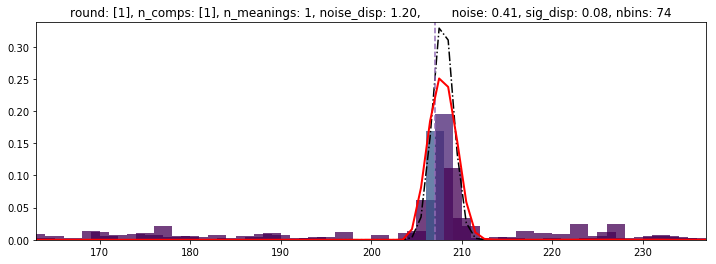

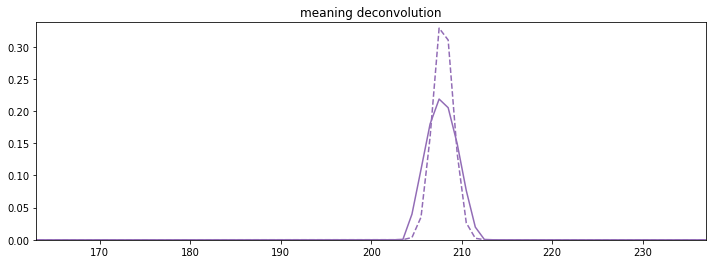

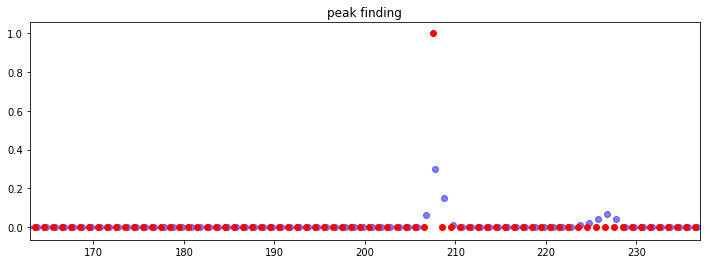

sim 2160/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1502, losses_deconv_av: 0.1308
sim 2170/500000 losses_peak_av: 0.0135, losses_smooth_av: 0.1469, losses_deconv_av: 0.1318
sim 2180/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1461, losses_deconv_av: 0.1334
sim 2190/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1483, losses_deconv_av: 0.1344
sim 2200/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1517, losses_deconv_av: 0.1347
[(187, 0.821, 30818), (204, 0.179, 6799)]
meaning_means: [[14], [31]], meaning_sigmas: [[6], [7]]


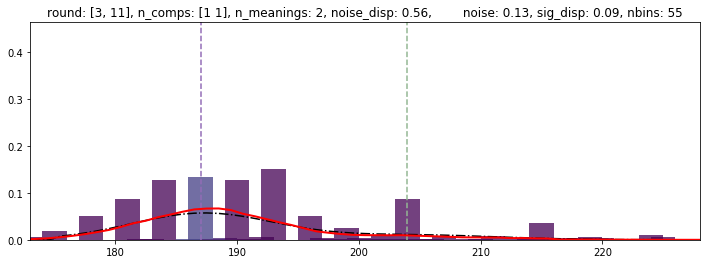

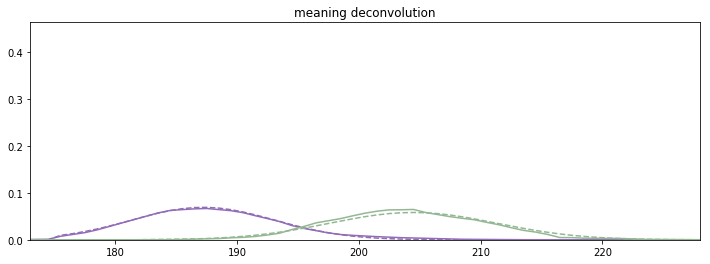

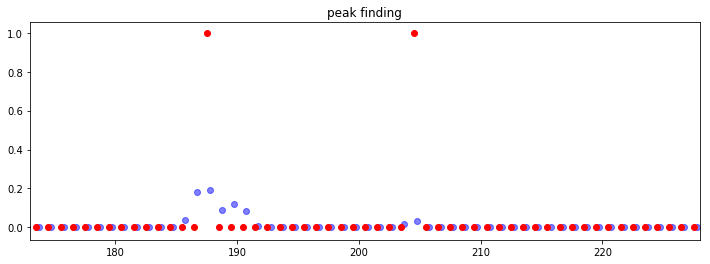

sim 2210/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1537, losses_deconv_av: 0.1352
sim 2220/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1551, losses_deconv_av: 0.1346
sim 2230/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1554, losses_deconv_av: 0.1338
sim 2240/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1521, losses_deconv_av: 0.1328
sim 2250/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1485, losses_deconv_av: 0.1329
[(231, 1.0, 26686)]
meaning_means: [[145, 149, 145, 144, 147]], meaning_sigmas: [[19, 7, 7, 7, 7]]


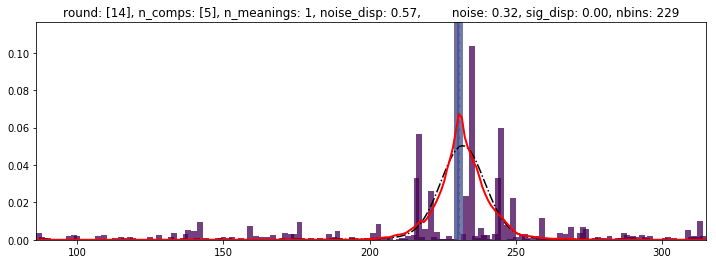

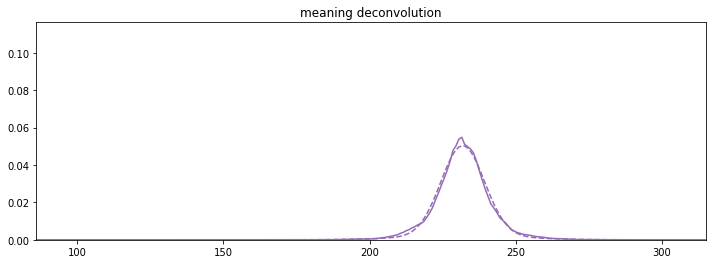

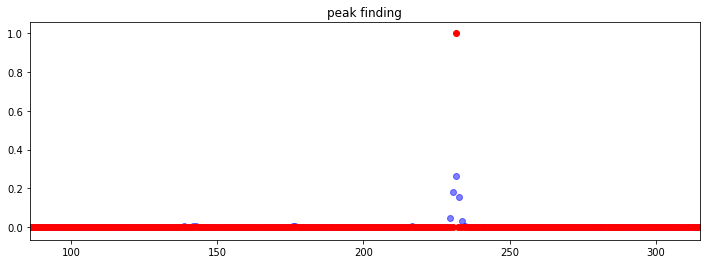

sim 2260/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1484, losses_deconv_av: 0.1321
sim 2270/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1463, losses_deconv_av: 0.1317
sim 2280/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1476, losses_deconv_av: 0.1316
sim 2290/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1441, losses_deconv_av: 0.1307
sim 2300/500000 losses_peak_av: 0.0136, losses_smooth_av: 0.1411, losses_deconv_av: 0.1303
[(163, 0.486, 29325), (208, 0.514, 21445)]
meaning_means: [[31, 28, 31, 35], [79, 80, 78]], meaning_sigmas: [[16, 3, 3, 3], [8, 3, 3]]


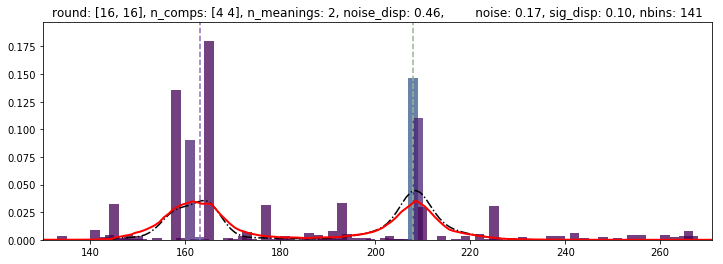

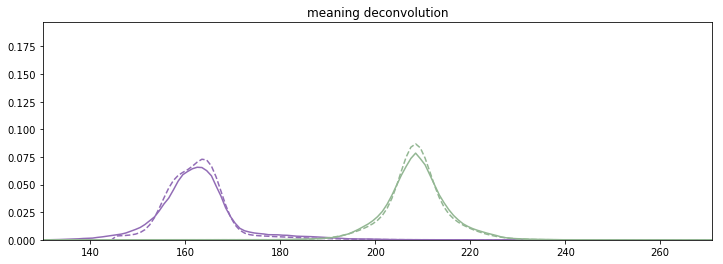

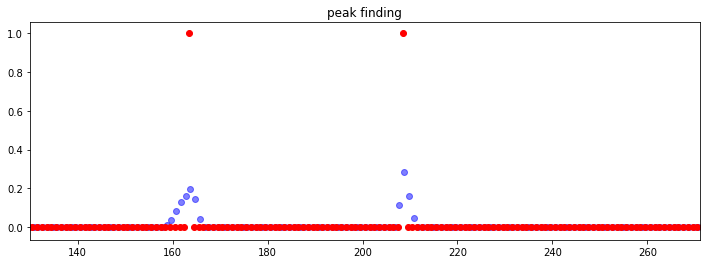

KeyboardInterrupt: 

In [28]:
# first_run = 0

nsims = 500000

losses_peak = []
losses_deconv = []
losses_smooth = []
lamb = 0.01
losses_peak_av = []
losses_deconv_av = []
loss_smooth_av = []

bsize = 32

for sim in range(nsims):
#     n_bins = np.random.randint(10, 601)
    Xbatch = []
    Zbatch = []
    Zhatbatch = []
    modes_batch = []
    wts_batch = []
    pdf_batch = []
    for _ in range(bsize):
        data = generator.generate()
        modes_onehot, meaning_wts = data['modes_onehot'], data['meaning_wts']
        meaning_modes, meaning_wts_onehot = data['meaning_modes'], data['meaning_wts_onehot']
        meaning_pdfs = data['meaning_pdfs']
        meaning_n_obs = data['meaning_n_obs']
        n_bins = data['n_bins']
        x, smoother_input, peakinput, deconv_input, meaning_modes, meaning_pdfs, pdf, _ = prepare_network_input_output(
            data['obs'], data['pdf'], meaning_modes, meaning_pdfs)
 
        Xbatch.append(smoother_input)
        Zbatch.append(deconv_input)
        
        deconv_target = np.stack(meaning_pdfs, 0)
        Zhatbatch.append(deconv_target)
        
        modes_onehot, wts_final = data['modes_onehot'], data['meaning_wts']
        modes_onehot, start = standardize_bins(modes_onehot)
#         modes, wts_final_onehot = data['meaning_modes'], data['meaning_wts_onehot']
#         modes_onehot, start = standardize_bins(modes_onehot)
#         modes += start

        modes_batch.append(modes_onehot)
#         wts_batch.append(wts_final_onehot)
        pdf_batch.append(pdf)

    Xbatch = tf.constant(np.concatenate(Xbatch, 0), tf.float32)
    Zbatch = tf.constant(np.concatenate(Zbatch, 0), tf.float32)
    Zhatbatch = tf.constant(np.concatenate(Zhatbatch, 0), tf.float32)
    Zhatbatch = tf.expand_dims(Zhatbatch, -1)
    Phatbatch = tf.constant(np.stack(pdf_batch, 0), tf.float32)
    Phatbatch = tf.expand_dims(Phatbatch, -1)
    modes_batch = tf.constant(np.expand_dims(np.stack(modes_batch, 0), -1), tf.float32)
    
#     wts_batch = tf.constant(np.expand_dims(np.stack(wts_batch, 0), -1), tf.float32))
#     _, loss_smooth, loss_peak = model_smoother.train_on_batch(Xbatch, [Phatbatch, modes_batch])
     
    _, loss_smooth, loss_peak = model_smoother.train_on_batch(
         Xbatch, [Phatbatch, modes_batch])
    loss_deconv = model_deconv.train_on_batch(
         Zbatch, Zhatbatch)
    loss_smooth = float(loss_smooth)
    loss_peak = float(loss_peak)
    loss_deconv = float(loss_deconv)
#     loss_smooth = float(model_smoother.train_on_batch(Xbatch, Phatbatch))
#     loss_deconv = float(model_deconv.train_on_batch(Zbatch, Zhatbatch))

    losses_peak.append(loss_peak)
    losses_deconv.append(loss_deconv)
    losses_smooth.append(loss_smooth)

    if sim == 0:
#         smooth, peaks = model_smoother(Xbatch)
        smooth, peaks = model_smoother(Xbatch)
        deconv = model_deconv(Zbatch)
        if first_run == 0:
            first_run = 1
#             loss_peak_ = 0.04  # loss_peak
#             loss_deconv_ = 0.4  # loss_deconv
#             loss_smooth_ = 0.35  # loss_smooth
            loss_peak_ = loss_peak
            loss_deconv_ = loss_deconv
            loss_smooth_ = loss_smooth
            
            losses_peak_av = [loss_peak_]
            losses_deconv_av = [loss_deconv_]
            losses_smooth_av = [loss_smooth_]
#             print(losses_peak_av, losses_deconv_av, losses_smooth_av)
#             tv_ = tv2(yhat)
#             tv_trend_ = tv_trend(yhat)
#             kl_ = kl(Ybatch, yhat)
#             shrink_ = ridge(yhat)
#             ll_ = llhood(Ybatch, yhat)
            lasso_ = lasso(peaks)
        else:
            losses_peak_av = [loss_peak_]
            losses_smooth_av = [loss_smooth_]
            losses_deconv_av = [loss_deconv_]
    else:
        loss_peak_ = lamb * losses_peak[-1] + (1.0 - lamb) * losses_peak_av[-1]
        loss_deconv_ = lamb * losses_deconv[-1] + (1.0 - lamb) * losses_deconv_av[-1]
        loss_smooth_ = lamb * losses_smooth[-1] + (1.0 - lamb) * losses_smooth_av[-1]
        losses_peak_av.append(loss_peak_)
        losses_smooth_av.append(loss_smooth_)
        losses_deconv_av.append(loss_deconv_)

#     yhat = model(Xbatch)
#     peaks = model_peaks(Xbatch)
#     signal_pred = []
    
#     tv_ += lamb * (tv2(yhat) - tv_)
#     tv_trend_ += lamb * (tv_trend(yhat) - tv_trend_)
#     shrink_ += lamb * (ridge(yhat) - shrink_)
#     ll_ += lamb * (llhood(Ybatch, yhat) - ll_)
#     kl_ += lamb * (kl(Ybatch, yhat) - kl_)
#     lasso_ += lamb * (lasso(peaks) - lasso_)
        
    if sim == 0 or (sim + 1) % 10 == 0:
        print(f"sim {sim + 1}/{nsims}", end="")
#         print(f"losses_av: {losses_av[-1]:.4f}, tv: {tv_:.5f}, tv_trend: {tv_trend_:.5f}, ", end="")
#         print(f" shrink: {shrink_:.4f}, ll: {ll_:.4f}, KL: {kl_:.4f}, nbins: {n_bins}  lasso: {lasso_:.4f}")
        print(f" losses_peak_av: {losses_peak_av[-1]:.4f}, losses_smooth_av: {losses_smooth_av[-1]:.4f}, losses_deconv_av: {losses_deconv_av[-1]:.4f}")
#         print("")
        
    loss_every = 500
    max_loss_range = 2500
    if (sim + 1) % loss_every == 0:
        plt.figure(figsize=(9, 4))
        n = len(losses_peak_av)
        start = max(n - max_loss_range, 0) 
        plt.plot(range(start, n), losses_peak_av[start:], c="red")
        plt.axvline(max(n - loss_every, 0), c="black")
        plt.title("loss peaks")
        plt.show()
        plt.figure(figsize=(9, 4))
        n = len(losses_deconv_av)
        start = max(n - max_loss_range, 0) 
        plt.plot(range(start, n), losses_deconv_av[start:], c="blue")
        plt.axvline(max(n - loss_every, 0), c="black")
        plt.title("loss deconv")
        plt.show()
        plt.figure(figsize=(9, 4))
        n = len(losses_smooth_av)
        start = max(n - max_loss_range, 0) 
        plt.plot(range(start, n), losses_smooth_av[start:], c="blue")
        plt.axvline(max(n - loss_every, 0), c="black")
        plt.title("loss smooth")
        plt.show()

    if sim == 0 or (sim + 1) % 50 == 0:
        plot_test_case()
        plt.show()
        
    if (sim + 1) % 100 == 0:
#         model.save_weights("tmp_one_to_rule_them_all_skl_elite.h5")
#         model_peaks.save_weights("tmp_smoother.h5")
        model_deconv.save_weights("tmp_back_to_two_deconv.h5")
        model_smoother.save_weights("tmp_back_to_two_smoother.h5")
